In [1]:
import nltk
from nltk import FreqDist
#nltk.download('stopwords') # run this one time

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

D:\Tools\Anaconda\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [3]:
#df = pd.read_json('meta_AMAZON_FASHION.json', lines=True)
review = pd.read_json('Appliances.json', lines=True)

In [4]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602777 entries, 0 to 602776
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         602777 non-null  int64 
 1   vote            65262 non-null   object
 2   verified        602777 non-null  bool  
 3   reviewTime      602777 non-null  object
 4   reviewerID      602777 non-null  object
 5   asin            602777 non-null  object
 6   style           137973 non-null  object
 7   reviewerName    602762 non-null  object
 8   reviewText      602453 non-null  object
 9   summary         602649 non-null  object
 10  unixReviewTime  602777 non-null  int64 
 11  image           9258 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 51.2+ MB


In [5]:
review = review.dropna(subset=["reviewText"])

In [6]:
review = review.dropna(subset=["summary"])

In [7]:
review.head(3)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,"Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.\n\nAlan Gregerman discusses the meaning of...",Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,"Becoming more innovative by opening yourself to conversations with ""strangers""",1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,"Alan Gregerman believes that innovation comes from viewing problems from different and fresh perspectives. In The Necessity of Strangers, he tells short, simple stories to help free us from curre...",The World from Different Perspectives,1381363200,NaN


### Data Preprocessing

In [8]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

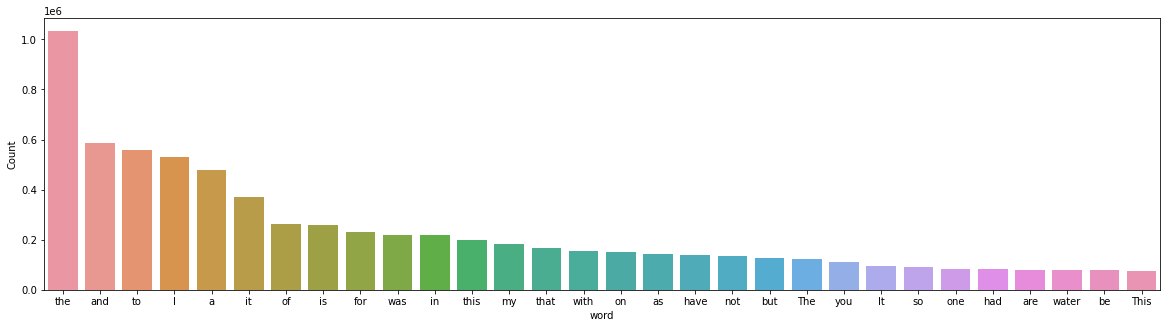

In [9]:
freq_words(review['reviewText'])

In [10]:
df = review['reviewText'].to_frame()
#df[['reviewText']]

In [11]:
#remove stop words as evidenced from previous diagram

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Arthur
[nltk_data]     Wen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
stop = set(stopwords.words('english'))

In [14]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', text).replace("\n", " ").replace("&", " ")

df['noHTML'] = df['reviewText'].apply(remove_html_tags)

In [15]:
df['noStopword'] = df['noHTML'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

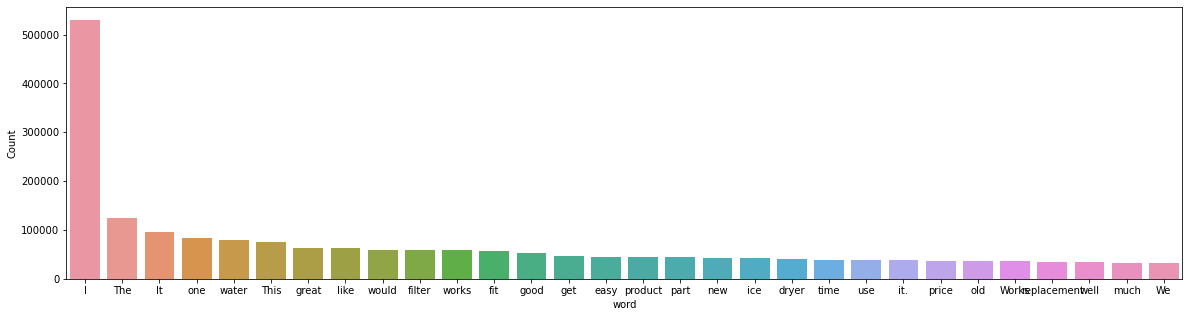

In [16]:
freq_words(df['noStopword'])

In [17]:
df['noStopword'] = df['noStopword'].str.replace("[^a-zA-Z#]", " ")
df['noStopword'] = df['noStopword'].str.lower()

In [18]:
df['tokenized'] = df['noStopword'].apply(nltk.word_tokenize)

In [19]:
df['tagged'] = df['tokenized'].apply(nltk.pos_tag)

In [20]:
df['nouns'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

In [21]:
df['verbs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']])

In [22]:
df['adjs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag.startswith("J")])

In [23]:
df['adverbs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag.startswith("RB")])

In [24]:
df.head()

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs
0,"Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.\n\nAlan Gregerman discusses the meaning of...","Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable. Alan Gregerman discusses the meaning of h...",not one thing book seemed obvious original thought however clarity author explains innovation happens remarkable alan gregerman discusses meaning human interactions kinds situations tend inspir...,"[not, one, thing, book, seemed, obvious, original, thought, however, clarity, author, explains, innovation, happens, remarkable, alan, gregerman, discusses, meaning, human, interactions, kinds, si...","[(not, RB), (one, CD), (thing, NN), (book, NN), (seemed, VBD), (obvious, JJ), (original, JJ), (thought, VBN), (however, RB), (clarity, NN), (author, NN), (explains, VBZ), (innovation, NN), (happen...","[thing, book, clarity, author, innovation, gregerman, interactions, kinds, situations, inspire, thinking, innovation, things, people, situations, patterns, identifies, ingredients, innovation, peo...","[seemed, thought, explains, happens, discusses, meaning, tend, leads, include, communicate, make, includes, compelled, wouldn, leading, recommend]","[obvious, original, remarkable, alan, human, original, clear, certain, normal, gregerman, interact, t, phenomenon, occur, individual, i, common, apparent]","[not, however, likely, normally, sometimes, sometimes, away]"
1,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,i enjoyed dr alan gregerman s weekly blog two previous books since taking innovation class alan decade ago he opened eyes seeing world fresh way also taught structured techniques i use in...,"[i, enjoyed, dr, alan, gregerman, s, weekly, blog, two, previous, books, since, taking, innovation, class, alan, decade, ago, he, opened, eyes, seeing, world, fresh, way, also, taught, structured,...","[(i, JJ), (enjoyed, VBD), (dr, NN), (alan, NN), (gregerman, JJ), (s, JJ), (weekly, JJ), (blog, NN), (two, CD), (previous, JJ), (books, NNS), (since, IN), (taking, VBG), (innovation, NN), (class, N...","[dr, alan, blog, books, innovation, class, alan, decade, eyes, world, way, techniques, creative, problem, skills, individuals, difference, invention, innovation, innovation, adaption, inventions, ...","[enjoyed, taking, opened, seeing, taught, i, use, solving, alan, makes, borrowed, cultures, surrounded, builds, delves, making, addressing, challenge, tackling, seeking, alan, borrows, storytellin...","[i, gregerman, s, weekly, previous, fresh, structured, increase, teams, untangles, easier, see, proven, previous, excellent, great, mix, memorable, newest, previous, critical, alternative, full, e...","[also, much, heavily, highly, recently, highly, s]"
2,"Alan Gregerman believes that innovation comes from viewing problems from different and fresh perspectives. In The Necessity of Strangers, he tells short, simple stories to help free us from curre...","Alan Gregerman believes that innovation comes from viewing problems from different and fresh perspectives. In The Necessity of Strangers, he tells short, simple stories to help free us from curre...",alan gregerman believes innovation comes viewing problems different fresh perspectives in the necessity strangers tells short simple stories help free us current legacy views problem hand he ...,"[alan, gregerman, believes, innovation, comes, viewing, problems, different, fresh, perspectives,

In [25]:
df['Token_Count'] = df['tokenized'].str.len()

In [26]:
def norm_lemm_v_a_func(text):
    '''
    Lemmatize tokens from string
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens
    Step 3: Use word_tokenize() to get tokens from generated string        
    Step 4: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''
    words1 = word_tokenize(text)
    text1 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='v') for word in words1])
    words2 = word_tokenize(text1)
    text2 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='a') for word in words2])
    return text2

def norm_lemm_v_a_func_token(text):
    '''
    Lemmatize tokens from string
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens
    Step 3: Use word_tokenize() to get tokens from generated string        
    Step 4: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''

    text1 = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    text2 = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text1]
    return text2

In [27]:
df['lemmatized'] = df['noStopword'].apply(norm_lemm_v_a_func)

In [28]:
df.head()

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized
0,"Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.\n\nAlan Gregerman discusses the meaning of...","Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable. Alan Gregerman discusses the meaning of h...",not one thing book seemed obvious original thought however clarity author explains innovation happens remarkable alan gregerman discusses meaning human interactions kinds situations tend inspir...,"[not, one, thing, book, seemed, obvious, original, thought, however, clarity, author, explains, innovation, happens, remarkable, alan, gregerman, discusses, meaning, human, interactions, kinds, si...","[(not, RB), (one, CD), (thing, NN), (book, NN), (seemed, VBD), (obvious, JJ), (original, JJ), (thought, VBN), (however, RB), (clarity, NN), (author, NN), (explains, VBZ), (innovation, NN), (happen...","[thing, book, clarity, author, innovation, gregerman, interactions, kinds, situations, inspire, thinking, innovation, things, people, situations, patterns, identifies, ingredients, innovation, peo...","[seemed, thought, explains, happens, discusses, meaning, tend, leads, include, communicate, make, includes, compelled, wouldn, leading, recommend]","[obvious, original, remarkable, alan, human, original, clear, certain, normal, gregerman, interact, t, phenomenon, occur, individual, i, common, apparent]","[not, however, likely, normally, sometimes, sometimes, away]",78,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...
1,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,i enjoyed dr alan gregerman s weekly blog two previous books since taking innovation class alan decade ago he opened eyes seeing world fresh way also taught structured techniques i use in...,"[i, enjoyed, dr, alan, gregerman, s, weekly, blog, two, previous, books, since, taking, innovation, class, alan, decade, ago, he, opened, eyes, seeing, world, fresh, way, also, taught, structured,...","[(i, JJ), (enjoyed, VBD), (dr, NN), (alan, NN), (gregerman, JJ), (s, JJ), (weekly, JJ), (blog, NN), (two, CD), (previous, JJ), (books, NNS), (since, IN), (taking, VBG), (innovation, NN), (class, N...","[dr, alan, blog, books, innovation, class, alan, decade, eyes, world, way, techniques, creative, problem, skills, individuals, difference, invention, innovation, innovation, adaption, inventions, ...","[enjoyed, taking, opened, seeing, taught, i, use, solving, alan, makes, borrowed, cultures, surrounded, builds, delves, making, addressing, challenge, tackling, seeking, alan, borrows, storytellin...","[i, gregerman, s, weekly, previous, fresh, structured, increase, teams, untangles, easier, see, proven, previous, excellent, great, mix, memorable, newest, previous, critical, alternative, full, e...","[also, much, heavily, highly, recently, highly, s]",166,i enjoy dr alan gregerman s weekly blog two previous book since take innovation class alan decade ago he open eye see world fresh way also teach structure techniques i use increase creative proble...
2,"Alan Gregerman believes that innovation comes from viewing problems from different and fresh perspectives. In The Necessity of Strangers, he tells short, simple stories to help free us from curre...","Alan Gregerman believes that innovation comes from viewing prob

### EDA

In [29]:
def remove_single_char_func(text, threshold=1):
    '''
    Removes single characters from string, if present
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Removes words whose length falls below the threshold (by default = 1)
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with removed words whose length was below the threshold (by default = 1)
    ''' 
    threshold = threshold
    
    words = word_tokenize(text)
    text = ' '.join([word for word in words if len(word) > threshold])
    return text

In [30]:
df['clean'] = df['lemmatized'].apply(remove_single_char_func)
df['clean'] = df.apply(lambda x: remove_single_char_func(x["lemmatized"], threshold=2), axis = 1)

In [31]:
df.head()

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean
0,"Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.\n\nAlan Gregerman discusses the meaning of...","Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable. Alan Gregerman discusses the meaning of h...",not one thing book seemed obvious original thought however clarity author explains innovation happens remarkable alan gregerman discusses meaning human interactions kinds situations tend inspir...,"[not, one, thing, book, seemed, obvious, original, thought, however, clarity, author, explains, innovation, happens, remarkable, alan, gregerman, discusses, meaning, human, interactions, kinds, si...","[(not, RB), (one, CD), (thing, NN), (book, NN), (seemed, VBD), (obvious, JJ), (original, JJ), (thought, VBN), (however, RB), (clarity, NN), (author, NN), (explains, VBZ), (innovation, NN), (happen...","[thing, book, clarity, author, innovation, gregerman, interactions, kinds, situations, inspire, thinking, innovation, things, people, situations, patterns, identifies, ingredients, innovation, peo...","[seemed, thought, explains, happens, discusses, meaning, tend, leads, include, communicate, make, includes, compelled, wouldn, leading, recommend]","[obvious, original, remarkable, alan, human, original, clear, certain, normal, gregerman, interact, t, phenomenon, occur, individual, i, common, apparent]","[not, however, likely, normally, sometimes, sometimes, away]",78,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...
1,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,i enjoyed dr alan gregerman s weekly blog two previous books since taking innovation class alan decade ago he opened eyes seeing world fresh way also taught structured techniques i use in...,"[i, enjoyed, dr, alan, gregerman, s, weekly, blog, two, previous, books, since, taking, innovation, class, alan, decade, ago, he, opened, eyes, seeing, world, fresh, way, also, taught, structured,...","[(i, JJ), (enjoyed, VBD), (dr, NN), (alan, NN), (gregerman, JJ), (s, JJ), (weekly, JJ), (blog, NN), (two, CD), (previous, JJ), (books, NNS), (since, IN), (taking, VBG), (innovation, NN), (class, N...","[dr, alan, blog, books, innovation, class, alan, decade, eyes, world, way, techniques, creative, problem, skills, individuals, difference, invention, innovation, innovation, adaption, inventions, ...","[enjoyed, taking, opened, seeing, taught, i, use, solving, alan, makes, borrowed, cultures, surrounded, builds, delves, making, addressing, challenge, tackling, seeking, alan, borrows, storytellin...","[i, gregerman, s, weekly, previous, fresh, structured, increase, teams, untangles, easier, see, proven, previous, excellent, great, mix, memorable, newest, previous, critical, alternative, full, e...","[also, much, heavily, highly, recently, highly, s]",166,i enjoy dr alan gregerman s weekly blog two previous book since take innovation class alan decade ago he open eye see world fresh way also teach structure techniques i use increase creative proble...,enjoy alan gregerman weekly blog two previous book since take

In [32]:
df.to_csv("FASHION_review_cleaned.csv")

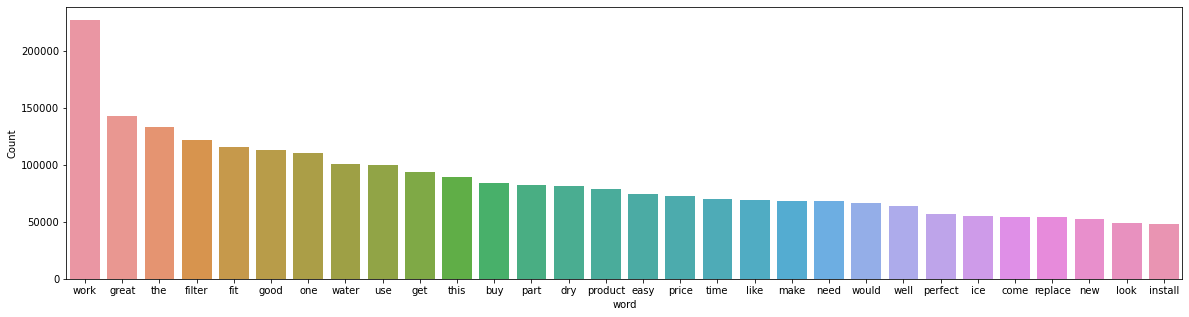

In [33]:
freq_words(df['clean'])

In [34]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

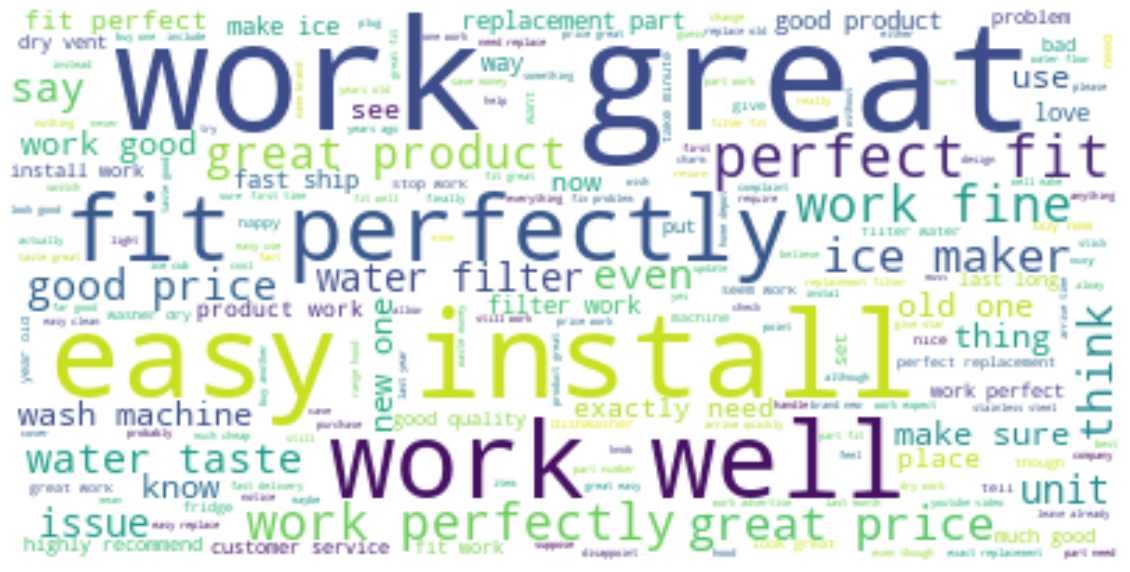

In [35]:
text = " ".join(i for i in df['clean'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Extraction

In [124]:
from nltk.collocations import *
from nltk.util import ngrams

In [125]:
word_list = ' '.join([i for i in df['clean']]).split()

In [126]:
(pd.Series(nltk.ngrams(word_list, 2)).value_counts())[:20]

(work, great)        45045
(easy, install)      28461
(work, well)         21283
(fit, perfectly)     16820
(work, fine)         14964
(work, perfectly)    14483
(ice, maker)         14238
(perfect, fit)       13492
(great, price)       13443
(work, like)         10756
(water, taste)       10348
(great, product)      9867
(water, filter)       9578
(good, price)         9239
(wash, machine)       8713
(make, sure)          7829
(old, one)            7524
(exactly, need)       7091
(work, good)          6838
(new, one)            6711
dtype: int64

In [127]:
(pd.Series(nltk.ngrams(word_list, 3)).value_counts())[:20]

(easy, install, work)      4338
(work, like, charm)        3964
(water, taste, great)      2962
(work, great, easy)        2194
(water, taste, good)       2136
(work, like, new)          1961
(install, work, great)     1928
(great, easy, install)     1841
(save, lot, money)         1733
(filter, work, great)      1582
(would, buy, again)        1451
(product, work, great)     1433
(fit, perfectly, work)     1378
(seem, work, fine)         1337
(very, easy, install)      1292
(product, great, price)    1250
(work, great, work)        1227
(big, box, store)          1193
(seem, work, well)         1171
(work, great, the)         1160
dtype: int64

In [128]:
search_word = ["love", "like", "hate", "great", "nice", 'the']

no_opinion = ' '.join((filter(lambda val: val not in search_word, list(word_list)))).split()

In [129]:
(pd.Series(nltk.ngrams(no_opinion, 2)).value_counts())[:20]

(easy, install)        28462
(work, well)           21390
(fit, perfectly)       16822
(work, fine)           14972
(work, perfectly)      14494
(ice, maker)           14238
(perfect, fit)         13510
(water, taste)         10415
(water, filter)         9705
(good, price)           9422
(wash, machine)         8722
(make, sure)            7829
(work, good)            7711
(old, one)              7529
(exactly, need)         7097
(new, one)              6713
(make, ice)             6427
(replacement, part)     6359
(fast, ship)            6283
(would, recommend)      6275
dtype: int64

In [130]:
(pd.Series(nltk.ngrams(no_opinion, 3)).value_counts())[:20]

(easy, install, work)         4355
(water, taste, good)          2215
(work, easy, install)         1785
(save, lot, money)            1733
(would, buy, again)           1452
(fit, perfectly, work)        1385
(seem, work, fine)            1340
(very, easy, install)         1298
(big, box, store)             1193
(seem, work, well)            1176
(ice, maker, work)            1132
(would, highly, recommend)    1039
(perfectly, easy, install)    1010
(perfect, fit, work)           949
(get, pay, for)                941
(filter, work, well)           937
(filter, fit, perfectly)       928
(fit, work, perfectly)         902
(would, recommend, anyone)     883
(fit, easy, install)           878
dtype: int64

## Sentiment Analysis

In [131]:
review['overall'].value_counts()
df['rating'] = review['overall']

In [132]:
def label_func(rating):
    if rating <= 2:
        return 'negative'
    if rating >= 4:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_func)

In [133]:
positive_review = df[(df["sentiment"] == 'positive')]['clean'].to_frame()
neutral_review = df[(df["sentiment"] == 'neutral')]['clean'].to_frame()
negative_review = df[(df["sentiment"] == 'negative')]['clean'].to_frame()

In [134]:
pos_clean = ' '.join([i for i in positive_review['clean']]).split()
neutral_clean = ' '.join([i for i in neutral_review['clean']]).split()
neg_clean = ' '.join([i for i in negative_review['clean']]).split()

In [135]:
pos_clean = ' '.join((filter(lambda val: val not in search_word, list(pos_clean)))).split()
neutral_clean = ' '.join((filter(lambda val: val not in search_word, list(neutral_clean)))).split()
neg_clean = ' '.join((filter(lambda val: val not in search_word, list(neg_clean)))).split()

In [136]:
text_corpus_positive_review = ' '.join(pos_clean)
text_corpus_neutral_review = ' '.join(neutral_clean)
text_corpus_negative_review = ' '.join(neg_clean)

In [137]:
def most_common_word_func(text, n_words=25):

    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    n_words = n_words
    
    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

In [138]:
df_most_common_words_text_corpus_positive_review = most_common_word_func(text_corpus_positive_review)
df_most_common_words_text_corpus_neutral_review = most_common_word_func(text_corpus_neutral_review)
df_most_common_words_text_corpus_negative_review = most_common_word_func(text_corpus_negative_review)

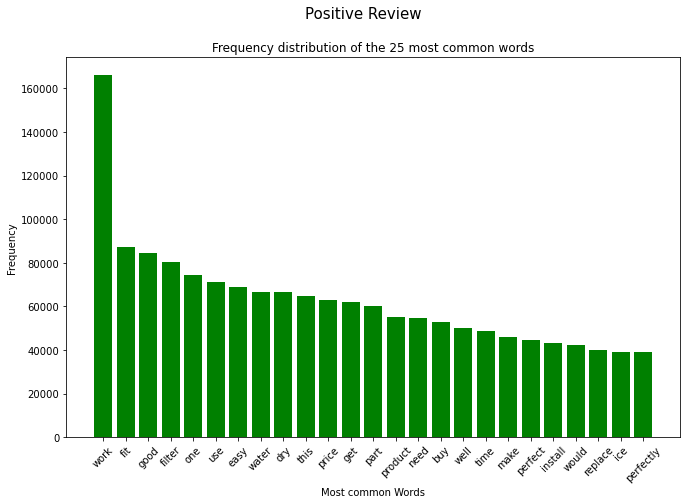

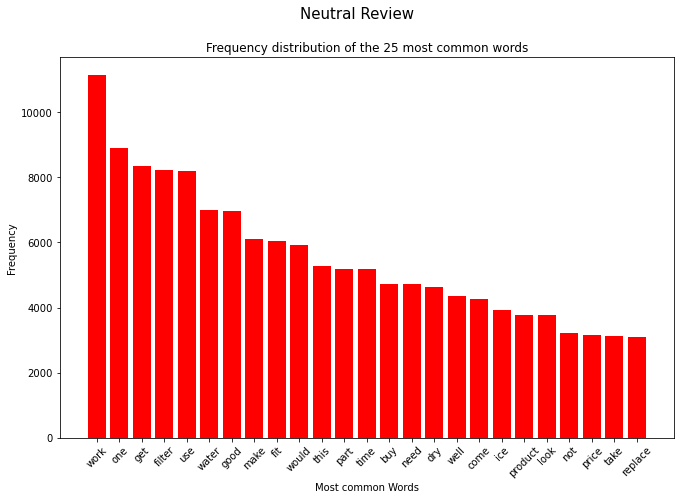

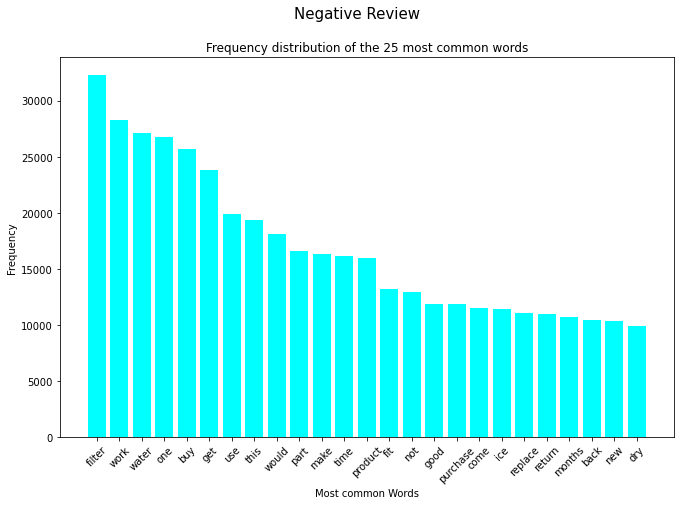

In [139]:
splited_data = [df_most_common_words_text_corpus_positive_review,
                df_most_common_words_text_corpus_neutral_review,
                df_most_common_words_text_corpus_negative_review]

color_list = ['green', 'red', 'cyan']
title_list = ['Positive Review', 'Neutral Review', 'Negative Review']


for item in range(3):
    plt.figure(figsize=(11,7))
    plt.bar(splited_data[item]['Word'], 
            splited_data[item]['Frequency'],
            color=color_list[item])
    plt.xticks(rotation = 45)
    plt.xlabel('Most common Words')
    plt.ylabel("Frequency")
    plt.title("Frequency distribution of the 25 most common words")
    plt.suptitle(title_list[item], fontsize=15)
    plt.show()

## Topic Modeling

In [140]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

dictionary = corpora.Dictionary(df['tokenized'])

In [141]:
doc_term_matrix = [dictionary.doc2bow(word) for word in df['tokenized']]

In [142]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [143]:
##lda_model_1 = Lda_object(DT_matrix, num_topics=2, id2word = dictionary)

print(lda_model.print_topics(num_topics=6, num_words=5))

[(2, '0.053*"fit" + 0.050*"great" + 0.035*"product" + 0.034*"perfect" + 0.034*"price"'), (1, '0.080*"i" + 0.022*"one" + 0.019*"it" + 0.016*"part" + 0.012*"refrigerator"'), (3, '0.081*"easy" + 0.071*"great" + 0.065*"install" + 0.065*"works" + 0.054*"ice"'), (6, '0.064*"i" + 0.036*"it" + 0.013*"s" + 0.012*"love" + 0.011*"like"'), (5, '0.026*"the" + 0.021*"dryer" + 0.011*"old" + 0.010*"door" + 0.009*"new"'), (4, '0.068*"i" + 0.013*"water" + 0.011*"time" + 0.010*"it" + 0.010*"the"')]


In [144]:
from textblob import TextBlob

df = df[df.Token_Count>2] # Whole Dataset

def norm_lemm_v_a_func_token(text):
    '''
    Lemmatize tokens
    
    Step 1: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens     
    Step 2: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''

    text1 = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    text2 = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text1]
    return text2

# Filter out nouns (product-related features), verbs and subjective adverbs & adjs which reflect strong customer opinions.
word_len_threshold = 2
df['tagged_filtered'] = df['tagged'].apply(lambda x: [word for word, tag in x 
                                                    if len(word) > word_len_threshold and
                                                        (   tag.startswith("N") 
                                                        or tag.startswith("V")
                                                        or (tag.startswith("RB") and TextBlob(word).sentiment.subjectivity>0)
                                                        or (tag.startswith("J") and TextBlob(word).sentiment.subjectivity>0)  )])

df["tokenized_filtered"] = df['tagged_filtered'].apply(norm_lemm_v_a_func_token)

df

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,tagged_filtered,tokenized_filtered,bigram,sentiment
0,"Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.\n\nAlan Gregerman discusses the meaning of...","Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable. Alan Gregerman discusses the meaning of h...",not one thing book seemed obvious original thought however clarity author explains innovation happens remarkable alan gregerman discusses meaning human interactions kinds situations tend inspir...,"[not, one, thing, book, seemed, obvious, original, thought, however, clarity, author, explains, innovation, happens, remarkable, alan, gregerman, discusses, meaning, human, interactions, kinds, si...","[(not, RB), (one, CD), (thing, NN), (book, NN), (seemed, VBD), (obvious, JJ), (original, JJ), (thought, VBN), (however, RB), (clarity, NN), (author, NN), (explains, VBZ), (innovation, NN), (happen...","[thing, book, clarity, author, innovation, gregerman, interactions, kinds, situations, inspire, thinking, innovation, things, people, situations, patterns, identifies, ingredients, innovation, peo...","[seemed, thought, explains, happens, discusses, meaning, tend, leads, include, communicate, make, includes, compelled, wouldn, leading, recommend]","[obvious, original, remarkable, alan, human, original, clear, certain, normal, gregerman, interact, t, phenomenon, occur, individual, i, common, apparent]","[not, however, likely, normally, sometimes, sometimes, away]",78,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,5,"[thing, book, seemed, obvious, original, thought, clarity, author, explains, innovation, happens, remarkable, gregerman, discusses, meaning, human, interactions, kinds, situations, tend, inspire, ...","[thing, book, seem, obvious, original, think, clarity, author, explain, innovation, happen, remarkable, gregerman, discuss, mean, human, interactions, kinds, situations, tend, inspire, original, c...","[not one, one thing, thing book, book seem, seem obvious, obvious original, original think, think however, however clarity, clarity author, author explain, explain innovation, innovation happen, h...",positive
1,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,i enjoyed dr alan gregerman s weekly blog two previous books since taking innovation class alan decade ago he opened eyes seeing world fresh way also taught structured techniques i use in...,"[i, enjoyed, dr, alan, gregerman, s, weekly, blog, two, previous, books, since, taking, innovation, class, alan, decade, ago, he, opened, eyes, seeing, world, fresh, way, also, taught, structured,...","[(i, JJ), (enjoyed, VBD), (dr, NN), (alan, NN), (gregerman, JJ), (s, JJ), (weekly, JJ), (blog, NN), (two, CD), (previous, JJ), (books, NNS), (since, IN), (taking, VBG), (innovation, NN), (class, N...","[dr, alan, blog, books, innovation, class, alan, decade, eyes, world, way, techniques, creative, problem, skills, individuals, difference, invention, innovation, innovation, adaption, inventions, ...","[enjoyed, taking, opened, seeing, taught, i, 

In [145]:
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

In [146]:
# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos = df[df.sentiment=="positive"]
df_neu = df[df.sentiment=="neutral"]
df_neg = df[df.sentiment=="negative"]

pos_dictionary = corpora.Dictionary(df_pos['tokenized_filtered'])
neu_dictionary = corpora.Dictionary(df_neu['tokenized_filtered'])
neg_dictionary = corpora.Dictionary(df_neg['tokenized_filtered'])

# Filter out tokens appear in 1) less than 1% of all reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
pos_dictionary.filter_extremes(no_below=0.01*len(pos_dictionary.token2id), no_above=0.8) 
neu_dictionary.filter_extremes(no_below=0.01*len(neu_dictionary.token2id), no_above=0.8) 
neg_dictionary.filter_extremes(no_below=0.01*len(neg_dictionary.token2id), no_above=0.8)

pos_doc_term_matrix = [pos_dictionary.doc2bow(word) for word in df_pos['tokenized_filtered']]
neu_doc_term_matrix = [neu_dictionary.doc2bow(word) for word in df_neu['tokenized_filtered']]
neg_doc_term_matrix = [neg_dictionary.doc2bow(word) for word in df_neg['tokenized_filtered']]

In [147]:
# LDA model parameter tuning

# from gensim.test.utils import common_texts
# from gensim.corpora.dictionary import Dictionary

# lda = gensim.models.ldamodel.LdaModel(corpus=pos_doc_term_matrix,
#                                            #id2word=pos_dictionary,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

pos_lda_model = LDA(corpus=pos_doc_term_matrix, id2word=pos_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)
neu_lda_model = LDA(corpus=neu_doc_term_matrix, id2word=neu_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)
neg_lda_model = LDA(corpus=neg_doc_term_matrix, id2word=neg_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)

In [148]:
# Topics in positive reviews.

print(pos_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.033*"dry" + 0.026*"use" + 0.026*"replace" + 0.021*"ice" + 0.020*"get"'), (1, '0.066*"order" + 0.062*"time" + 0.059*"fast" + 0.058*"ship" + 0.047*"part"'), (2, '0.045*"buy" + 0.033*"good" + 0.030*"get" + 0.023*"save" + 0.022*"issue"'), (3, '0.315*"fit" + 0.170*"perfect" + 0.074*"work" + 0.052*"happy" + 0.041*"item"'), (4, '0.179*"filter" + 0.146*"water" + 0.060*"refrigerator" + 0.032*"job" + 0.031*"quickly"'), (5, '0.217*"easy" + 0.108*"work" + 0.107*"install" + 0.071*"fine" + 0.066*"far"'), (6, '0.079*"need" + 0.052*"exactly" + 0.049*"look" + 0.043*"love" + 0.042*"machine"'), (7, '0.252*"great" + 0.194*"work" + 0.127*"price" + 0.123*"good" + 0.104*"product"'), (8, '0.086*"part" + 0.074*"replacement" + 0.062*"fridge" + 0.039*"unit" + 0.032*"door"'), (9, '0.093*"perfectly" + 0.054*"original" + 0.039*"instal" + 0.038*"taste" + 0.035*"purchase"')]


The positive reviews mainly centered around the following topics:

1. Product Quality:
    (1) Material: "soft", "top"
    (2) Size: "fit"
    (3) Style: "cute", "look as expected", "color"
2. Product Price
    (1) "discount"
    (2) "worth the price"
    
Especially, many adverbs and adjs are used to express their strong satisfaction (different from neu/neg reviews): top, very, great, love, super, really.
   
This reveals that customers cares about product quality and prices, with material, size, style, discount as top deciding fatcors. They would describe good products as "look as expected from pictures".

In [149]:
# Topics in neutral reviews.

print(neu_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.111*"dry" + 0.049*"side" + 0.041*"install" + 0.040*"easy" + 0.038*"number"'), (1, '0.081*"part" + 0.048*"product" + 0.042*"price" + 0.036*"good" + 0.035*"need"'), (2, '0.041*"get" + 0.027*"use" + 0.023*"unit" + 0.019*"break" + 0.017*"time"'), (3, '0.276*"work" + 0.083*"fine" + 0.061*"have" + 0.048*"seem" + 0.042*"wire"'), (4, '0.127*"fit" + 0.044*"top" + 0.033*"door" + 0.033*"small" + 0.029*"nice"'), (5, '0.071*"look" + 0.067*"ice" + 0.054*"light" + 0.039*"set" + 0.034*"fan"'), (6, '0.078*"fridge" + 0.056*"return" + 0.049*"product" + 0.035*"arrive" + 0.034*"brand"'), (7, '0.060*"need" + 0.039*"use" + 0.037*"turn" + 0.036*"really" + 0.034*"good"'), (8, '0.081*"hood" + 0.076*"item" + 0.046*"high" + 0.043*"load" + 0.040*"kitchen"'), (9, '0.045*"filter" + 0.042*"water" + 0.025*"work" + 0.024*"old" + 0.024*"new"')]


The neutral reviews mainly centered around the following topics:

1. Family:
    (1) "daugher"
2. Product Size (controversial)
    (1) Some customers stated "fit"
    (2) Some stated that size might not be just right: "large" & "small", "short", "little"
    (3) "return": Some products might be returned
3. Product Look
    (1) "nice", "cute", "like picture"
   
Compared with positive reviews, neutral reviews became more controversial in consumer opinions, especially in product size. Many customers might be satisfied with the product quality and look, but just the size didn't fit. So they would give a neutral star.

In [150]:
# Topics in negative reviews.

print(neg_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.134*"fit" + 0.036*"look" + 0.030*"light" + 0.029*"stave" + 0.024*"screw"'), (1, '0.133*"do" + 0.088*"have" + 0.050*"know" + 0.048*"be" + 0.048*"stay"'), (2, '0.041*"door" + 0.038*"take" + 0.035*"top" + 0.031*"taste" + 0.030*"open"'), (3, '0.079*"ice" + 0.065*"refrigerator" + 0.059*"fridge" + 0.045*"unit" + 0.043*"work"'), (4, '0.096*"dry" + 0.052*"samsung" + 0.046*"washer" + 0.044*"clothe" + 0.039*"load"'), (5, '0.141*"part" + 0.067*"service" + 0.057*"call" + 0.050*"model" + 0.041*"tell"'), (6, '0.037*"buy" + 0.031*"work" + 0.030*"get" + 0.025*"time" + 0.021*"water"'), (7, '0.142*"filter" + 0.066*"water" + 0.031*"product" + 0.029*"order" + 0.028*"original"'), (8, '0.082*"repair" + 0.056*"issue" + 0.041*"number" + 0.034*"control" + 0.033*"contact"'), (9, '0.071*"return" + 0.054*"item" + 0.034*"wrong" + 0.033*"product" + 0.028*"damage"')]


The negative reviews mainly centered around the following topics:

1. Product Size (controversial)
    (1) Some customers stated "fit" (but might be not fit and the not was not captured by topic modeling)
    (2) Some stated that size might not be just right: "large" & "small", "short", "little"
    (3) "return": Some products might be returned
2. Product Price
    (1) "cheap"
   
Compared with pos/neu reviews, negative reviews are still controversial in consumer opinions, especially in product size. Also, the product might be cheap or look cheap, which did not match customers' expectations.

In [151]:
# Aggregate review tokens into bi-grams and tri-grams to better understand structured user opinions instead of scattered words.
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos_ng = df[df.sentiment=="positive"]
df_neu_ng = df[df.sentiment=="neutral"]
df_neg_ng = df[df.sentiment=="negative"]

ng_pos_dictionary = corpora.Dictionary(df_pos_ng['bigram'])
ng_neu_dictionary = corpora.Dictionary(df_neu_ng['bigram'])
ng_neg_dictionary = corpora.Dictionary(df_neg_ng['bigram'])

# Filter out tokens appear in 1) less than 3 reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
ng_pos_dictionary.filter_extremes(no_below=3, no_above=0.8) 
ng_neu_dictionary.filter_extremes(no_below=3, no_above=0.8) 
ng_neg_dictionary.filter_extremes(no_below=3, no_above=0.8)

ng_pos_doc_term_matrix = [ng_pos_dictionary.doc2bow(word) for word in df_pos_ng['bigram']]
ng_neu_doc_term_matrix = [ng_neu_dictionary.doc2bow(word) for word in df_neu_ng['bigram']]
ng_neg_doc_term_matrix = [ng_neg_dictionary.doc2bow(word) for word in df_neg_ng['bigram']]

df

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,tagged_filtered,tokenized_filtered,bigram,sentiment
0,"Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.\n\nAlan Gregerman discusses the meaning of...","Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable. Alan Gregerman discusses the meaning of h...",not one thing book seemed obvious original thought however clarity author explains innovation happens remarkable alan gregerman discusses meaning human interactions kinds situations tend inspir...,"[not, one, thing, book, seemed, obvious, original, thought, however, clarity, author, explains, innovation, happens, remarkable, alan, gregerman, discusses, meaning, human, interactions, kinds, si...","[(not, RB), (one, CD), (thing, NN), (book, NN), (seemed, VBD), (obvious, JJ), (original, JJ), (thought, VBN), (however, RB), (clarity, NN), (author, NN), (explains, VBZ), (innovation, NN), (happen...","[thing, book, clarity, author, innovation, gregerman, interactions, kinds, situations, inspire, thinking, innovation, things, people, situations, patterns, identifies, ingredients, innovation, peo...","[seemed, thought, explains, happens, discusses, meaning, tend, leads, include, communicate, make, includes, compelled, wouldn, leading, recommend]","[obvious, original, remarkable, alan, human, original, clear, certain, normal, gregerman, interact, t, phenomenon, occur, individual, i, common, apparent]","[not, however, likely, normally, sometimes, sometimes, away]",78,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,5,"[thing, book, seemed, obvious, original, thought, clarity, author, explains, innovation, happens, remarkable, gregerman, discusses, meaning, human, interactions, kinds, situations, tend, inspire, ...","[thing, book, seem, obvious, original, think, clarity, author, explain, innovation, happen, remarkable, gregerman, discuss, mean, human, interactions, kinds, situations, tend, inspire, original, c...","[not one, one thing, thing book, book seem, seem obvious, obvious original, original think, think however, however clarity, clarity author, author explain, explain innovation, innovation happen, h...",positive
1,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,i enjoyed dr alan gregerman s weekly blog two previous books since taking innovation class alan decade ago he opened eyes seeing world fresh way also taught structured techniques i use in...,"[i, enjoyed, dr, alan, gregerman, s, weekly, blog, two, previous, books, since, taking, innovation, class, alan, decade, ago, he, opened, eyes, seeing, world, fresh, way, also, taught, structured,...","[(i, JJ), (enjoyed, VBD), (dr, NN), (alan, NN), (gregerman, JJ), (s, JJ), (weekly, JJ), (blog, NN), (two, CD), (previous, JJ), (books, NNS), (since, IN), (taking, VBG), (innovation, NN), (class, N...","[dr, alan, blog, books, innovation, class, alan, decade, eyes, world, way, techniques, creative, problem, skills, individuals, difference, invention, innovation, innovation, adaption, inventions, ...","[enjoyed, taking, opened, seeing, taught, i, 

In [152]:
ng_pos_dictionary.token2id

{'alan gregerman': 0,
 'away home': 1,
 'clear think': 2,
 'common sense': 3,
 'not one': 4,
 'one thing': 5,
 'original and': 6,
 'original think': 7,
 'seem obvious': 8,
 'these things': 9,
 'this include': 10,
 'book the': 11,
 'challenge the': 12,
 'easy see': 13,
 'excellent great': 14,
 'highly recommend': 15,
 'make connections': 16,
 'make much': 17,
 'make much easy': 18,
 'much easy': 19,
 'necessity strangers': 20,
 'outside one': 21,
 'people talk': 22,
 'personal experience': 23,
 'power make': 24,
 'problem solve': 25,
 'since take': 26,
 'the book': 27,
 'the necessity': 28,
 'the necessity strangers': 29,
 'way also': 30,
 'would highly': 31,
 'would highly recommend': 32,
 'matter the': 33,
 'quick read': 34,
 'read keep': 35,
 'point view': 36,
 'already know': 37,
 'another type': 38,
 'best way': 39,
 'catch eye': 40,
 'change life': 41,
 'connect the': 42,
 'could also': 43,
 'could change': 44,
 'could say': 45,
 'course could': 46,
 'create new': 47,
 'else need'

In [153]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

ng_pos_lda_model = LDA(corpus=ng_pos_doc_term_matrix, id2word=ng_pos_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neu_lda_model = LDA(corpus=ng_neu_doc_term_matrix, id2word=ng_neu_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neg_lda_model = LDA(corpus=ng_neg_doc_term_matrix, id2word=ng_neg_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)

In [154]:
# Topics in positive reviews.

for topic in ng_pos_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.010*"good quality" + 0.009*"far good" + 0.007*"fix problem" + 0.006*"washer dry" + 0.005*"dry work" + 0.005*"very good"
Topic 1: 0.087*"work great" + 0.035*"fit perfectly" + 0.012*"fit work" + 0.009*"filter work" + 0.008*"much good" + 0.007*"seem work"
Topic 2: 0.014*"fast ship" + 0.014*"water filter" + 0.009*"like original" + 0.009*"good product" + 0.008*"install work" + 0.008*"arrive time"
Topic 3: 0.025*"work fine" + 0.018*"water taste" + 0.015*"fit perfect" + 0.011*"make sure" + 0.008*"taste great" + 0.008*"arrive quickly"
Topic 4: 0.026*"great price" + 0.017*"great product" + 0.011*"perfect replacement" + 0.010*"work good" + 0.010*"thank you" + 0.009*"replacement part"
Topic 5: 0.011*"ice maker" + 0.009*"wash machine" + 0.006*"like new" + 0.005*"easy use" + 0.004*"year old" + 0.004*"just need"
Topic 6: 0.058*"easy install" + 0.044*"work well" + 0.035*"work perfectly" + 0.021*"good price" + 0.011*"work perfect" + 0.010*"old one"
Topic 7: 0.047*"perfect fit" + 0.031*"work

The positive reviews mainly centered around the following topics:

Pros:
1. Great quality
2. Size fit
3. Look good
4. Comfortable
5. Like Picture and Product Description
6. Discount

All compliments, very few complaints.
    
This is aligned with the word-level topic modeling on positive reviews.

In [155]:
# Topics in neutral reviews.

for topic in ng_neu_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.008*"replacement part" + 0.006*"fit perfectly" + 0.006*"long time" + 0.006*"water filter" + 0.006*"wash machine" + 0.005*"exact replacement"
Topic 1: 0.015*"easy install" + 0.012*"the product" + 0.010*"good product" + 0.007*"stave top" + 0.007*"cook top" + 0.007*"receive product"
Topic 2: 0.008*"make work" + 0.008*"look great" + 0.007*"work fine" + 0.006*"three star" + 0.006*"this product" + 0.005*"original part"
Topic 3: 0.012*"new one" + 0.010*"old one" + 0.007*"make sure" + 0.007*"stop work" + 0.006*"really like" + 0.005*"would buy"
Topic 4: 0.019*"work well" + 0.008*"give star" + 0.007*"look like" + 0.007*"look good" + 0.006*"fit well" + 0.006*"good quality"
Topic 5: 0.013*"customer service" + 0.010*"range hood" + 0.007*"year old" + 0.006*"the unit" + 0.006*"make ice" + 0.005*"get pay"
Topic 6: 0.007*"can not" + 0.006*"stainless steel" + 0.005*"part number" + 0.004*"still work" + 0.003*"filter water" + 0.003*"picture show"
Topic 7: 0.018*"work fine" + 0.015*"work great" 

The neutral reviews mainly centered around the following topics:

Pros:
1. Great quality
2. Size fit (for some)
3. Look good

Cons:
1. Size might be too large or small. Not fitting well.

Compliments and complaints mixed together.
    
This is aligned with the word-level topic modeling on neutral reviews. The major complaints centered around size due to online shopping.

In [156]:
# Topics in negative reviews.

for topic in ng_neg_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.021*"ice maker" + 0.008*"make ice" + 0.008*"send back" + 0.006*"poor quality" + 0.005*"model number" + 0.004*"the product"
Topic 1: 0.010*"never buy" + 0.008*"new one" + 0.007*"first one" + 0.006*"service call" + 0.006*"save money" + 0.006*"part number"
Topic 2: 0.007*"last months" + 0.006*"the water" + 0.005*"time money" + 0.005*"waste time" + 0.005*"break within" + 0.004*"shut off"
Topic 3: 0.011*"can not" + 0.010*"not buy" + 0.009*"very disappoint" + 0.007*"this product" + 0.006*"buy this" + 0.005*"buy product"
Topic 4: 0.015*"even though" + 0.008*"water flow" + 0.007*"don waste" + 0.007*"every time" + 0.006*"fit stave" + 0.005*"buy again"
Topic 5: 0.018*"stop work" + 0.010*"water filter" + 0.007*"years old" + 0.007*"water taste" + 0.006*"work well" + 0.006*"customer service"
Topic 6: 0.011*"customer service" + 0.009*"wash machine" + 0.008*"the filter" + 0.007*"work great" + 0.007*"buy another" + 0.006*"filter work"
Topic 7: 0.018*"waste money" + 0.015*"work fine" + 0.010

The negative reviews mainly centered around the following topics:

Cons:
1. Size: Not fitting well ("way big", "extra large").
2. Quality: "poorly make", "poor quality", "look cheap", "fall apart", "cheaply make".
3. Expectation: "very disappointing", "send back", "nothing like picture".
4. Price: "waste money".

Mostly complaints, few compliments.
    
This is aligned with the word-level topic modeling on negative reviews. The major complaints centered around size, quality, price, not as expectation. Customers also mentioned that they sended back the products.

In [157]:
# Try another set of params
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos_ng = df[df.sentiment=="positive"]
df_neu_ng = df[df.sentiment=="neutral"]
df_neg_ng = df[df.sentiment=="negative"]

ng_pos_dictionary = corpora.Dictionary(df_pos_ng['bigram'])
ng_neu_dictionary = corpora.Dictionary(df_neu_ng['bigram'])
ng_neg_dictionary = corpora.Dictionary(df_neg_ng['bigram'])

# Filter out tokens appear in 1) less than 50 reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
ng_pos_dictionary.filter_extremes(no_below=50, no_above=0.8) 
ng_neu_dictionary.filter_extremes(no_below=50, no_above=0.8) 
ng_neg_dictionary.filter_extremes(no_below=50, no_above=0.8)

ng_pos_doc_term_matrix = [ng_pos_dictionary.doc2bow(word) for word in df_pos_ng['bigram']]
ng_neu_doc_term_matrix = [ng_neu_dictionary.doc2bow(word) for word in df_neu_ng['bigram']]
ng_neg_doc_term_matrix = [ng_neg_dictionary.doc2bow(word) for word in df_neg_ng['bigram']]

df

,reviewText,noHTML,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,tagged_filtered,tokenized_filtered,bigram,sentiment
0,"Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.\n\nAlan Gregerman discusses the meaning of...","Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable. Alan Gregerman discusses the meaning of h...",not one thing book seemed obvious original thought however clarity author explains innovation happens remarkable alan gregerman discusses meaning human interactions kinds situations tend inspir...,"[not, one, thing, book, seemed, obvious, original, thought, however, clarity, author, explains, innovation, happens, remarkable, alan, gregerman, discusses, meaning, human, interactions, kinds, si...","[(not, RB), (one, CD), (thing, NN), (book, NN), (seemed, VBD), (obvious, JJ), (original, JJ), (thought, VBN), (however, RB), (clarity, NN), (author, NN), (explains, VBZ), (innovation, NN), (happen...","[thing, book, clarity, author, innovation, gregerman, interactions, kinds, situations, inspire, thinking, innovation, things, people, situations, patterns, identifies, ingredients, innovation, peo...","[seemed, thought, explains, happens, discusses, meaning, tend, leads, include, communicate, make, includes, compelled, wouldn, leading, recommend]","[obvious, original, remarkable, alan, human, original, clear, certain, normal, gregerman, interact, t, phenomenon, occur, individual, i, common, apparent]","[not, however, likely, normally, sometimes, sometimes, away]",78,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,5,"[thing, book, seemed, obvious, original, thought, clarity, author, explains, innovation, happens, remarkable, gregerman, discusses, meaning, human, interactions, kinds, situations, tend, inspire, ...","[thing, book, seem, obvious, original, think, clarity, author, explain, innovation, happen, remarkable, gregerman, discuss, mean, human, interactions, kinds, situations, tend, inspire, original, c...","[not one, one thing, thing book, book seem, seem obvious, obvious original, original think, think however, however clarity, clarity author, author explain, explain innovation, innovation happen, h...",positive
1,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,i enjoyed dr alan gregerman s weekly blog two previous books since taking innovation class alan decade ago he opened eyes seeing world fresh way also taught structured techniques i use in...,"[i, enjoyed, dr, alan, gregerman, s, weekly, blog, two, previous, books, since, taking, innovation, class, alan, decade, ago, he, opened, eyes, seeing, world, fresh, way, also, taught, structured,...","[(i, JJ), (enjoyed, VBD), (dr, NN), (alan, NN), (gregerman, JJ), (s, JJ), (weekly, JJ), (blog, NN), (two, CD), (previous, JJ), (books, NNS), (since, IN), (taking, VBG), (innovation, NN), (class, N...","[dr, alan, blog, books, innovation, class, alan, decade, eyes, world, way, techniques, creative, problem, skills, individuals, difference, invention, innovation, innovation, adaption, inventions, ...","[enjoyed, taking, opened, seeing, taught, i, 

In [158]:
ng_pos_dictionary.token2id

{'common sense': 0,
 'not one': 1,
 'one thing': 2,
 'these things': 3,
 'easy see': 4,
 'highly recommend': 5,
 'make much': 6,
 'make much easy': 7,
 'much easy': 8,
 'problem solve': 9,
 'since take': 10,
 'would highly': 11,
 'would highly recommend': 12,
 'already know': 13,
 'best way': 14,
 'change life': 15,
 'could also': 16,
 'could change': 17,
 'else need': 18,
 'family members': 19,
 'find right': 20,
 'get past': 21,
 'great deal': 22,
 'know well': 23,
 'never hear': 24,
 'never make': 25,
 'nothing else': 26,
 'one family': 27,
 'one favorite': 28,
 'someone else': 29,
 'the best': 30,
 'the new': 31,
 'time effort': 32,
 'well really': 33,
 'who know': 34,
 'the main': 35,
 'well receive': 36,
 'look around': 37,
 'look new': 38,
 'new good': 39,
 'can not': 40,
 'get work': 41,
 'great company': 42,
 'need get': 43,
 'right front': 44,
 'several years': 45,
 'the great': 46,
 'like say': 47,
 'need open': 48,
 'still recommend': 49,
 'that part': 50,
 'this good': 51,

In [159]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

ng_pos_lda_model2 = LDA(corpus=ng_pos_doc_term_matrix, id2word=ng_pos_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neu_lda_model2 = LDA(corpus=ng_neu_doc_term_matrix, id2word=ng_neu_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neg_lda_model2 = LDA(corpus=ng_neg_doc_term_matrix, id2word=ng_neg_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)

In [160]:
# Topics in positive reviews.

for topic in ng_pos_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.035*"perfect fit" + 0.019*"great product" + 0.014*"fast ship" + 0.013*"wash machine" + 0.010*"old one" + 0.009*"buy again"
Topic 1: 0.060*"work well" + 0.015*"good quality" + 0.012*"arrive time" + 0.012*"product work" + 0.011*"arrive quickly" + 0.010*"exact replacement"
Topic 2: 0.034*"great price" + 0.025*"good price" + 0.011*"much good" + 0.009*"fit great" + 0.009*"would recommend" + 0.008*"part work"
Topic 3: 0.056*"easy install" + 0.034*"work perfectly" + 0.024*"work fine" + 0.023*"work like" + 0.012*"perfect replacement" + 0.011*"thank you"
Topic 4: 0.018*"exactly need" + 0.012*"work perfect" + 0.010*"taste great" + 0.008*"fix problem" + 0.008*"water taste great" + 0.007*"still work"
Topic 5: 0.040*"fit perfectly" + 0.016*"ice maker" + 0.011*"make sure" + 0.010*"far good" + 0.008*"seem work" + 0.008*"new one"
Topic 6: 0.023*"water taste" + 0.019*"fit perfect" + 0.015*"highly recommend" + 0.012*"look great" + 0.011*"install work" + 0.011*"like new"
Topic 7: 0.119*"work g

In [161]:
# Topics in neutral reviews.

for topic in ng_neu_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.051*"look good" + 0.038*"the part" + 0.032*"fix problem" + 0.031*"wash machine" + 0.029*"take long" + 0.027*"original part"
Topic 1: 0.065*"work great" + 0.057*"ice maker" + 0.039*"can not" + 0.030*"good quality" + 0.028*"easy install" + 0.026*"part number"
Topic 2: 0.057*"customer service" + 0.056*"last long" + 0.032*"still work" + 0.031*"buy new" + 0.030*"ice cub" + 0.023*"filter water"
Topic 3: 0.109*"work fine" + 0.040*"look like" + 0.034*"replacement part" + 0.030*"old one" + 0.028*"even though" + 0.021*"need replace"
Topic 4: 0.047*"new one" + 0.040*"fit well" + 0.031*"the product" + 0.031*"like original" + 0.029*"water filter" + 0.027*"exact replacement"
Topic 5: 0.045*"range hood" + 0.038*"work good" + 0.032*"year old" + 0.029*"the unit" + 0.028*"make ice" + 0.026*"would like"
Topic 6: 0.055*"stainless steel" + 0.050*"make work" + 0.046*"not sure" + 0.040*"look nice" + 0.028*"really like" + 0.028*"get pay"
Topic 7: 0.114*"work well" + 0.057*"make sure" + 0.050*"give 

In [162]:
# Topics in negative reviews.

for topic in ng_neg_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.036*"ice maker" + 0.020*"wash machine" + 0.016*"never buy" + 0.015*"work great" + 0.013*"new one" + 0.011*"poor quality"
Topic 1: 0.042*"waste money" + 0.027*"even though" + 0.021*"years old" + 0.018*"work well" + 0.015*"would recommend" + 0.013*"doesnt fit"
Topic 2: 0.023*"water filter" + 0.022*"the filter" + 0.020*"not buy" + 0.017*"very disappoint" + 0.012*"control panel" + 0.012*"buy this"
Topic 3: 0.028*"work fine" + 0.018*"buy another" + 0.016*"another one" + 0.014*"first one" + 0.012*"last long" + 0.012*"two weeks"
Topic 4: 0.052*"stop work" + 0.016*"last months" + 0.011*"water come" + 0.010*"less year" + 0.010*"old filter" + 0.009*"next day"
Topic 5: 0.018*"one year" + 0.016*"brand new" + 0.016*"stainless steel" + 0.014*"buy product" + 0.014*"don buy" + 0.011*"pay for"
Topic 6: 0.031*"customer service" + 0.018*"can not" + 0.016*"make ice" + 0.016*"send back" + 0.015*"look like" + 0.013*"filter work"
Topic 7: 0.022*"this product" + 0.019*"water taste" + 0.016*"old one

## Feature Extraction

In [163]:
# Create an overall table that takes other variables into consideration
from datetime import datetime
from textblob import TextBlob
data = pd.concat([review[["reviewTime", "reviewerID","reviewerName","vote"]], df], axis=1).reset_index(drop=True)
data = data[data.Token_Count>2]
data["vote"].fillna(0, inplace=True)
data["vote"] = [int(date.replace(",","")) if "," in str(date) else date for date in data.vote.values]
data["vote"] = data["vote"].astype("float64")
data["reviewTime"] = ["-".join(np.array(date.replace(",", "").split())[[2,0,1]]) for date in data["reviewTime"]]
data["reviewTime"] = [datetime. strptime(date[:-1]+"0"+date[-1], '%Y-%m-%d') if len(date)<10 
                                      else datetime. strptime(date, '%Y-%m-%d') for date in data["reviewTime"]]
max_date = data["reviewTime"].max()
data["day_gap"] = [(max_date - date).days for date in data["reviewTime"]]
data["year-month"] = [date.strftime("%Y-%m") for date in data["reviewTime"]]
data["year"] = [date.strftime("%Y") for date in data["reviewTime"]]
data.head(3)

,reviewTime,reviewerID,reviewerName,vote,reviewText,noHTML,noStopword,tokenized,tagged,nouns,...,lemmatized,clean,rating,tagged_filtered,tokenized_filtered,bigram,sentiment,day_gap,year-month,year
0,2013-11-27,A3NHUQ33CFH3VM,Greeny,2.0,"Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.\n\nAlan Gregerman discusses the meaning of...","Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable. Alan Gregerman discusses the meaning of h...",not one thing book seemed obvious original thought however clarity author explains innovation happens remarkable alan gregerman discusses meaning human interactions kinds situations tend inspir...,"[not, one, thing, book, seemed, obvious, original, thought, however, clarity, author, explains, innovation, happens, remarkable, alan, gregerman, discusses, meaning, human, interactions, kinds, si...","[(not, RB), (one, CD), (thing, NN), (book, NN), (seemed, VBD), (obvious, JJ), (original, JJ), (thought, VBN), (however, RB), (clarity, NN), (author, NN), (explains, VBZ), (innovation, NN), (happen...","[thing, book, clarity, author, innovation, gregerman, interactions, kinds, situations, inspire, thinking, innovation, things, people, situations, patterns, identifies, ingredients, innovation, peo...",...,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,not one thing book seem obvious original think however clarity author explain innovation happen remarkable alan gregerman discuss mean human interactions kinds situations tend inspire original and...,5.0,"[thing, book, seemed, obvious, original, thought, clarity, author, explains, innovation, happens, remarkable, gregerman, discusses, meaning, human, interactions, kinds, situations, tend, inspire, ...","[thing, book, seem, obvious, original, think, clarity, author, explain, innovation, happen, remarkable, gregerman, discuss, mean, human, interactions, kinds, situations, tend, inspire, original, c...","[not one, one thing, thing book, book seem, seem obvious, obvious original, original think, think however, however clarity, clarity author, author explain, explain innovation, innovation happen, h...",positive,1772,2013-11,2013
1,2013-11-01,A3SK6VNBQDNBJE,Leif C. Ulstrup,0.0,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,I have enjoyed Dr. Alan Gregerman's weekly blog ([...] and two previous books since taking an innovation class with Alan over a decade ago. He opened my eyes to seeing the world in a fresh way an...,i enjoyed dr alan gregerman s weekly blog two previous books since taking innovation class alan decade ago he opened eyes seeing world fresh way also taught structured techniques i use in...,"[i, enjoyed, dr, alan, gregerman, s, weekly, blog, two, previous, books, since, taking, innovation, class, alan, decade, ago, he, opened, eyes, seeing, world, fresh, way, also, taught, structured,...","[(i, JJ), (enjoyed, VBD), (dr, NN), (alan, NN), (gregerman, JJ), (s, JJ), (weekly, JJ), (blog, NN), (two, CD), (previous, JJ), (books, NNS), (since, IN), (taking, VBG), (innovation, NN), (class, N...","[dr, alan, blog, books, innovation, class, alan, decade, eyes, world, way, techniques, creative, problem, skills, individuals, difference, invention, innovation, innovation, adaption, inventions, ...",...,i enjoy dr alan gregerman s weekly blog two previous book since take innovation class alan decade ago he open eye see world fresh way also teach structure techniques i use increase creative proble...,enjoy alan gregerman weekly blog two previous book since take innovati

In [164]:
# Check missing values: Only reviewerName has 81 missing values, could be ignored for now.
data.isnull().sum()

reviewTime             0
reviewerID             0
reviewerName          14
vote                   0
reviewText             0
noHTML                 0
noStopword             0
tokenized              0
tagged                 0
nouns                  0
verbs                  0
adjs                   0
adverbs                0
Token_Count            0
lemmatized             0
clean                  0
rating                 0
tagged_filtered        0
tokenized_filtered     0
bigram                 0
sentiment              0
day_gap                0
year-month             0
year                   0
dtype: int64

In [165]:
data[["vote","day_gap"]].corr()

,vote,day_gap
vote,1.000000,0.076855
day_gap,0.076855,1.000000


A high portion of review votes are 0, indicating they were not endorsed (or viewed) by any readers. The correlation between helpfulness votes and review publish dates (day_gap = max publish date - this review's publish date, counted in days) is low, indicating review views induced by publish time might not affect votes significantly.

In [166]:
data["rating"].sort_values().value_counts()

5.0    349065
4.0     66008
1.0     57579
3.0     28689
2.0     20031
Name: rating, dtype: int64

Text(0.5, 1.0, 'Distribution of User Ratings')

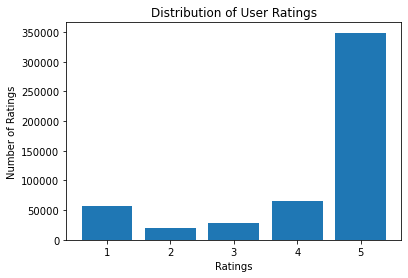

In [167]:
rating = pd.Series(data["rating"].value_counts()).sort_index()

plt.bar(rating.index, rating.values)
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.title("Distribution of User Ratings")

In [168]:
# Extract review features for importance ranking
import readability

data_tmp = data.copy() # Whole dataset

feature = pd.DataFrame()
feature["rating"] = data_tmp["rating"]
feature["vote"]  = data_tmp["vote"]
feature["length"] = data_tmp["Token_Count"]
feature["prop_of_noun"] = data_tmp["nouns"].str.len() / feature["length"]
feature["prop_of_verb"] = data_tmp["verbs"].str.len() / feature["length"]
feature["prop_of_adj_adverb"] = (data_tmp["adjs"].str.len() + data_tmp["adverbs"].str.len()) / feature["length"]
feature["subjectivity"] = data_tmp["clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)
feature["readability"] = data_tmp["reviewText"].apply(lambda x: readability.getmeasures(x, lang='en')['readability grades']['FleschReadingEase'])
feature

,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,5.0,2.0,78.0,0.397436,0.205128,0.320513,0.526600,30.952083
1,5.0,0.0,166.0,0.427711,0.210843,0.253012,0.482276,22.456818
2,5.0,0.0,79.0,0.468354,0.278481,0.151899,0.524644,-51.306186
3,5.0,0.0,51.0,0.431373,0.196078,0.254902,0.615267,-12.250385
4,5.0,10.0,366.0,0.385246,0.226776,0.210383,0.461467,63.851500
...,...,...,...,...,...,...,...,...
602335,5.0,0.0,4.0,0.250000,0.250000,0.250000,1.000000,45.645000
602336,2.0,0.0,4.0,0.750000,0.000000,0.250000,0.450000,78.872857
602337,5.0,0.0,3.0,0.666667,0.000000,0.333333,1.000000,83.320000
602338,1.0,0.0,28.0,0.392857,0.214286,0.142857,0.300000,62.850465


In [169]:
feature.corr() # No strong correlation feature pair existed

,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
rating,1.000000,0.000121,-0.153594,-0.025321,-0.091475,0.175849,0.215880,0.110603
vote,0.000121,1.000000,0.137603,-0.003571,0.013802,-0.017175,-0.006012,-0.049597
length,-0.153594,0.137603,1.000000,0.014339,0.053963,-0.124540,-0.052782,-0.499149
prop_of_noun,-0.025321,-0.003571,0.014339,1.000000,-0.459777,-0.409002,-0.029048,-0.034991
prop_of_verb,-0.091475,0.013802,0.053963,-0.459777,1.000000,-0.391863,-0.182040,-0.042821
prop_of_adj_adverb,0.175849,-0.017175,-0.124540,-0.409002,-0.391863,1.000000,0.282299,0.021321
subjectivity,0.215880,-0.006012,-0.052782,-0.029048,-0.182040,0.282299,1.000000,-0.027225
readability,0.110603,-0.049597,-0.499149,-0.034991,-0.042821,0.021321,-0.027225,1.000000


## Feature Importance

In [170]:
# Which feature best reflects user sentiment polarity (user satisfaction)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
                        feature.iloc[:,1:].to_numpy(), data_tmp["rating"].to_numpy().reshape(-1), test_size=0.2, random_state=42)

In [171]:
# Grid Search CV to find the best set of params
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}

## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_rfr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500],
                         'random_state': [18]})

In [172]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",CV_rfr.best_estimator_)
print("\n The best score across ALL searched params:\n",CV_rfr.best_score_)
print("\n The best parameters across ALL searched params:\n",CV_rfr.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=200,
                      random_state=18)

 The best score across ALL searched params:
 0.14694014572839323

 The best parameters across ALL searched params:
 {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 18}


In [173]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 7, random_state = 18).fit(X_train, y_train)

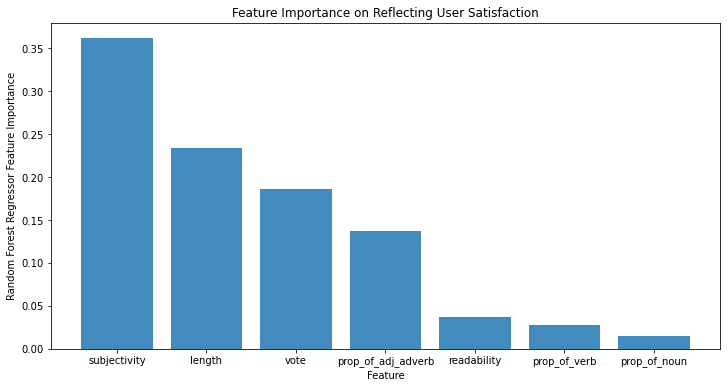

In [174]:
# Visualizations of Feature Importance
feature_name = feature.columns.values[1:][np.argsort(rf.feature_importances_)][::-1]
feature_importance = np.sort(rf.feature_importances_)[::-1]

fig = plt.figure(figsize=(12, 6))
plt.bar(feature_name, feature_importance, alpha=0.85)
plt.title("Feature Importance on Reflecting User Satisfaction")
plt.xlabel("Feature")
plt.ylabel("Random Forest Regressor Feature Importance")
plt.show()

It is observed that subjectivity has the highest feature importance on reflecting user satisfaction, followed by proportion of adjs & adverbs, length readability. This indicated that users with higher product satisfaction tended to give more subjective comments on the product, using higher portion of adjs and adverbs to highlight their feelings and satisfaction towards the product. Besides, users with higher satisfaction tended to write a longer review to document their experience in detail with higher corresponding text readability.

In [175]:
# Which features best influences review helpfulness
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
                                                        feature[["rating"] + list(feature.columns)[2:]].to_numpy(), data_tmp["vote"].to_numpy().reshape(-1), 
                                                        test_size=0.2, random_state=42)

In [176]:
# The grid search CV was costing too much time and will be ran later. For the code below, an initial set of params were used.
grid_vote = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18] 
}

## Grid Search function
CV_rfr_vote = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_vote, cv= 5)
CV_rfr_vote.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500],
                         'random_state': [18]})

In [177]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",CV_rfr_vote.best_estimator_)
print("\n The best score across ALL searched params:\n",CV_rfr_vote.best_score_)
print("\n The best parameters across ALL searched params:\n",CV_rfr_vote.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=500,
                      random_state=18)

 The best score across ALL searched params:
 0.9447856406056644

 The best parameters across ALL searched params:
 {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 18}


In [178]:
rf_vote = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(X_train, y_train)

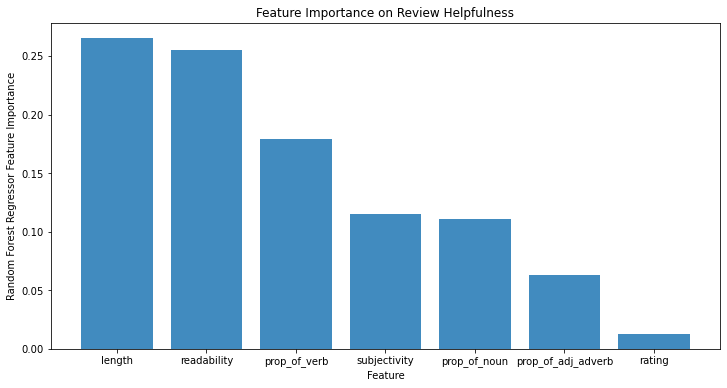

In [179]:
# Visualizations of Feature Importance
feature_name = np.array(["rating"] + list(feature.columns)[2:])[np.argsort(rf_vote.feature_importances_)][::-1]
feature_importance = np.sort(rf_vote.feature_importances_)[::-1]

fig = plt.figure(figsize=(12, 6))
plt.bar(feature_name, feature_importance, alpha=0.85)
plt.title("Feature Importance on Review Helpfulness")
plt.xlabel("Feature")
plt.ylabel("Random Forest Regressor Feature Importance")
plt.show()

Length is the most important feature that impacts review helpfulness, followed by readability, subjectivity, proportion of nouns. This implied that long reviews with good readability and subjective opinions had higher probability to be endorsed by readers since they provided more information on the product. The proportion of nouns might be correlated to the proportion of product-related feature terms mentioned in the reviews. A higher proportion of product-related feature terms indicated that more product features were discussed and evaluated in the reviews, thus providing readers with more relevant information on the product.

## Data Visualizations

In [180]:
# Aggregate current data for visualizations

feature_visual = pd.concat([data_tmp[["reviewTime","day_gap","year-month","year"]], feature], axis=1).reset_index(drop=True)
feature_visual

,reviewTime,day_gap,year-month,year,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2013-11-27,1772,2013-11,2013,5.0,2.0,78.0,0.397436,0.205128,0.320513,0.526600,30.952083
1,2013-11-01,1798,2013-11,2013,5.0,0.0,166.0,0.427711,0.210843,0.253012,0.482276,22.456818
2,2013-10-10,1820,2013-10,2013,5.0,0.0,79.0,0.468354,0.278481,0.151899,0.524644,-51.306186
3,2013-10-09,1821,2013-10,2013,5.0,0.0,51.0,0.431373,0.196078,0.254902,0.615267,-12.250385
4,2013-09-07,1853,2013-09,2013,5.0,10.0,366.0,0.385246,0.226776,0.210383,0.461467,63.851500
...,...,...,...,...,...,...,...,...,...,...,...,...
521367,2017-08-10,420,2017-08,2017,5.0,0.0,4.0,0.250000,0.250000,0.250000,1.000000,45.645000
521368,2018-08-01,64,2018-08,2018,2.0,0.0,4.0,0.750000,0.000000,0.250000,0.450000,78.872857
521369,2018-04-13,174,2018-04,2018,5.0,0.0,3.0,0.666667,0.000000,0.333333,1.000000,83.320000
521370,2018-03-23,195,2018-03,2018,1.0,0.0,28.0,0.392857,0.214286,0.142857,0.300000,62.850465


In [181]:
# Correlation analysis

feature_visual.corr()

,day_gap,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
day_gap,1.000000,-0.025253,0.076855,0.195148,-0.006604,0.035575,-0.075561,-0.018351,-0.144642
rating,-0.025253,1.000000,0.000121,-0.153594,-0.025321,-0.091475,0.175849,0.215880,0.110603
vote,0.076855,0.000121,1.000000,0.137603,-0.003571,0.013802,-0.017175,-0.006012,-0.049597
length,0.195148,-0.153594,0.137603,1.000000,0.014339,0.053963,-0.124540,-0.052782,-0.499149
prop_of_noun,-0.006604,-0.025321,-0.003571,0.014339,1.000000,-0.459777,-0.409002,-0.029048,-0.034991
prop_of_verb,0.035575,-0.091475,0.013802,0.053963,-0.459777,1.000000,-0.391863,-0.182040,-0.042821
prop_of_adj_adverb,-0.075561,0.175849,-0.017175,-0.124540,-0.409002,-0.391863,1.000000,0.282299,0.021321
subjectivity,-0.018351,0.215880,-0.006012,-0.052782,-0.029048,-0.182040,0.282299,1.000000,-0.027225
readability,-0.144642,0.110603,-0.049597,-0.499149,-0.034991,-0.042821,0.021321,-0.027225,1.000000


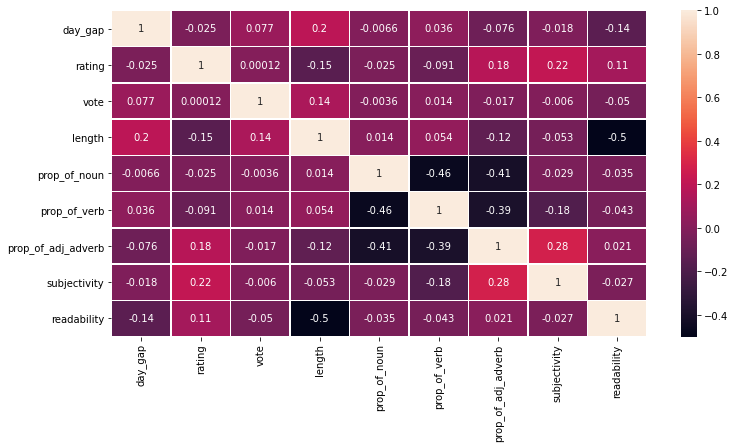

In [182]:
fig = plt.figure(figsize=(12, 6))
sns.heatmap(feature_visual.corr(), annot=True, linewidth=.5)

No strong correlation pairs existed.

In [183]:
# Trend Analysis

# Aggregate the features by year, taking mean as the aggregation method.
trend_data_by_year = feature_visual.iloc[:, 3:].groupby("year").mean().reset_index()
trend_data_by_year

,year,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2000,4.000000,2.000000,40.000000,0.350000,0.200000,0.350000,0.425344,40.470000
1,2001,4.000000,13.000000,56.000000,0.392857,0.160714,0.321429,0.383333,1.050220
2,2002,1.000000,2.000000,24.000000,0.416667,0.208333,0.291667,0.400000,64.715000
3,2003,3.000000,26.500000,58.500000,0.412113,0.147165,0.303866,0.314087,6.448875
4,2004,3.040000,13.720000,59.160000,0.405952,0.213377,0.260840,0.507428,32.777595
5,2005,3.593750,15.947917,97.833333,0.375557,0.219823,0.271037,0.507742,16.666521
6,2006,3.717557,23.419847,86.236641,0.379306,0.221183,0.264073,0.522939,33.334700
7,2007,3.651562,9.962500,63.415625,0.379459,0.222027,0.265264,0.496813,39.618415
8,2008,3.593519,11.159259,76.518519,0.383870,0.219135,0.265729,0.511217,34.355226
9,2009,3.653004,9.415497,61.569905,0.384591,0.222037,0.259754,0.508784,40.813718


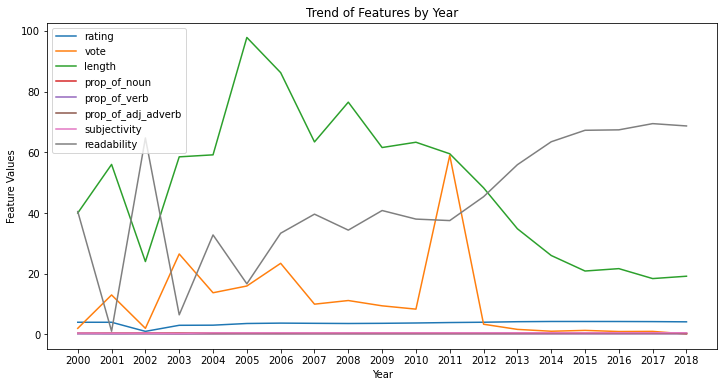

In [184]:
fig = plt.figure(figsize=(12, 6))
plt.plot(trend_data_by_year["year"], trend_data_by_year["rating"], label = "rating")
plt.plot(trend_data_by_year["year"], trend_data_by_year["vote"], label = "vote")
plt.plot(trend_data_by_year["year"], trend_data_by_year["length"], label = "length")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_noun"], label = "prop_of_noun")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_verb"], label = "prop_of_verb")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
plt.plot(trend_data_by_year["year"], trend_data_by_year["subjectivity"], label = "subjectivity")
plt.plot(trend_data_by_year["year"], trend_data_by_year["readability"], label = "readability")
plt.xlabel("Year")
plt.ylabel("Feature Values")
plt.title("Trend of Features by Year")
plt.legend()

[Text(0, 0.5, 'Feature Values'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Trend of readability by year')]

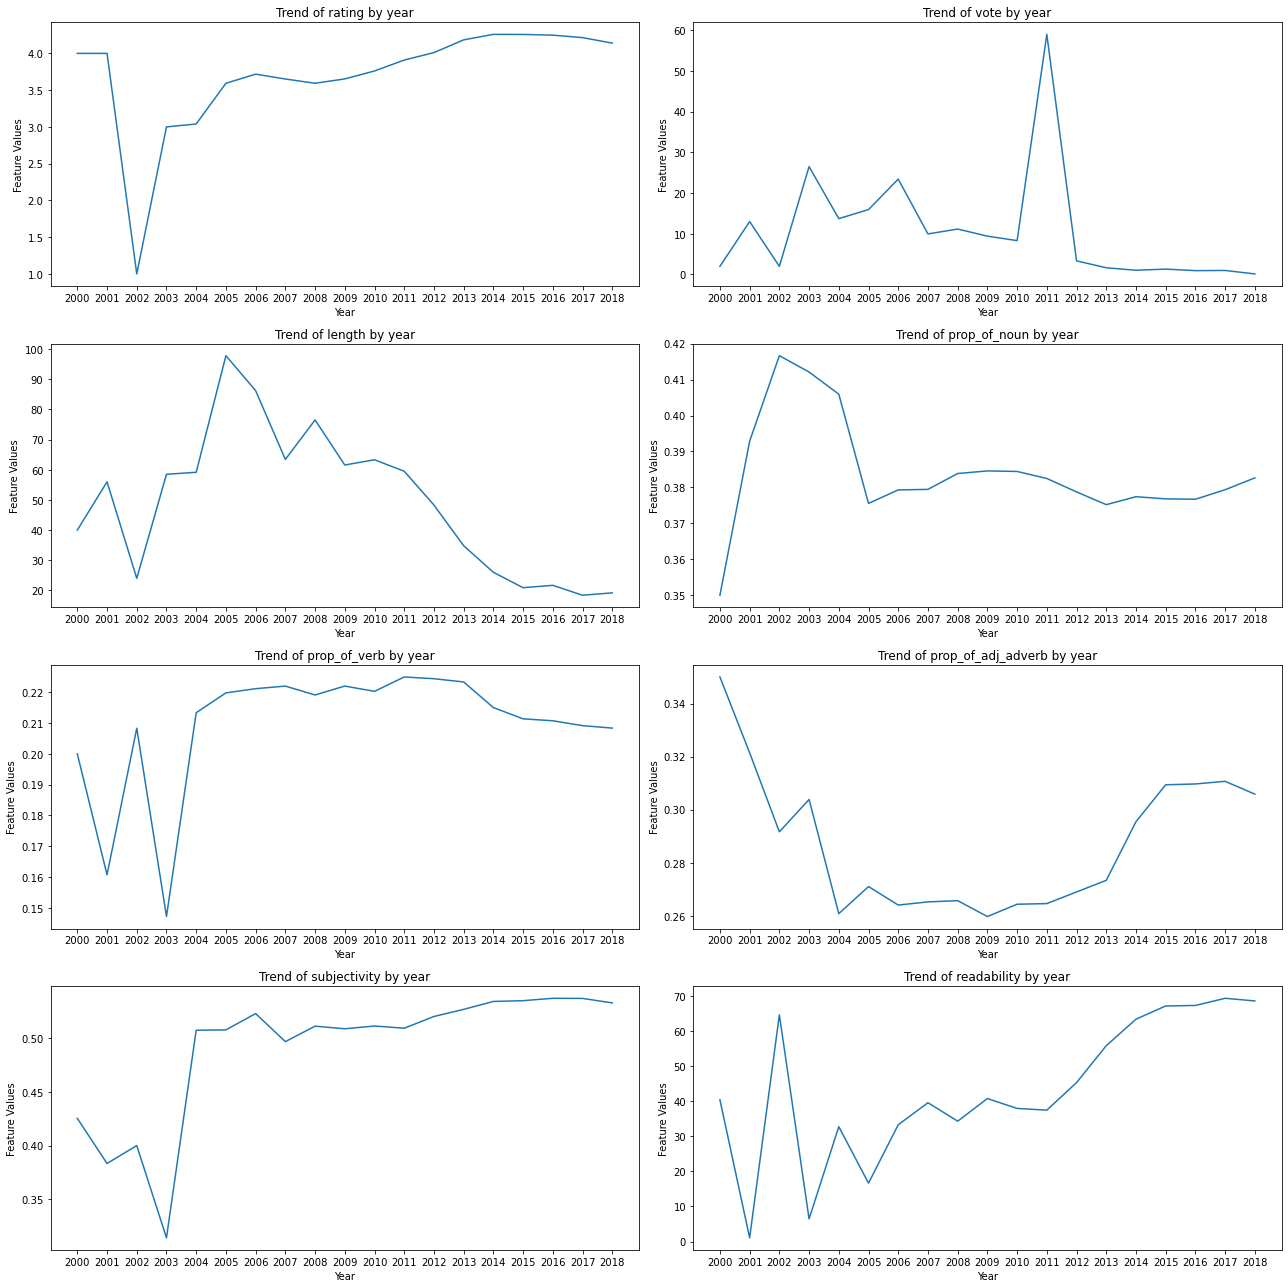

In [185]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(18, 18), tight_layout=True)
axes[0][0].plot(trend_data_by_year["year"], trend_data_by_year["rating"], label = "rating")
axes[0][0].set(title="Trend of rating by year", xlabel="Year", ylabel="Feature Values")
axes[0][1].plot(trend_data_by_year["year"], trend_data_by_year["vote"], label = "vote")
axes[0][1].set(title="Trend of vote by year", xlabel="Year", ylabel="Feature Values")
axes[1][0].plot(trend_data_by_year["year"], trend_data_by_year["length"], label = "length")
axes[1][0].set(title="Trend of length by year", xlabel="Year", ylabel="Feature Values")
axes[1][1].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_noun"], label = "prop_of_noun")
axes[1][1].set(title="Trend of prop_of_noun by year", xlabel="Year", ylabel="Feature Values")
axes[2][0].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_verb"], label = "prop_of_verb")
axes[2][0].set(title="Trend of prop_of_verb by year", xlabel="Year", ylabel="Feature Values")
axes[2][1].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
axes[2][1].set(title="Trend of prop_of_adj_adverb by year", xlabel="Year", ylabel="Feature Values")
axes[3][0].plot(trend_data_by_year["year"], trend_data_by_year["subjectivity"], label = "subjectivity")
axes[3][0].set(title="Trend of subjectivity by year", xlabel="Year", ylabel="Feature Values")
axes[3][1].plot(trend_data_by_year["year"], trend_data_by_year["readability"], label = "readability")
axes[3][1].set(title="Trend of readability by year", xlabel="Year", ylabel="Feature Values")

From the graph, there exist a general decreasing trend in rating, vote, length. Consumers might be more sensitive to product quality and write more succinct reviews. Also, the prop_of_adj_adverb and readability observed an increasing trend. Consumers might be expressing more personal and subjective experiences. With shorter reviews on average, the readability also increased accordingly.

In [186]:
# Aggregate the features by year & month, taking mean as the aggregation method.
trend_data_by_year_month = feature_visual.iloc[:, 2:].groupby("year-month").mean().reset_index()
trend_data_by_year_month

,year-month,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2000-10,4.000000,2.000000,40.000000,0.350000,0.200000,0.350000,0.425344,40.470000
1,2001-11,4.000000,13.000000,56.000000,0.392857,0.160714,0.321429,0.383333,1.050220
2,2002-02,1.000000,2.000000,24.000000,0.416667,0.208333,0.291667,0.400000,64.715000
3,2003-08,4.000000,39.000000,97.000000,0.474227,0.144330,0.257732,0.372619,-68.926000
4,2003-11,2.000000,14.000000,20.000000,0.350000,0.150000,0.350000,0.255556,81.823750
...,...,...,...,...,...,...,...,...,...
174,2018-06,4.132191,0.071535,18.212966,0.384256,0.205670,0.304837,0.533553,69.252873
175,2018-07,4.131569,0.076980,18.940415,0.391241,0.206663,0.303095,0.531165,68.369407
176,2018-08,4.187674,0.051032,19.008645,0.393439,0.201214,0.299135,0.538382,66.683733
177,2018-09,4.236025,0.022084,20.290545,0.385399,0.207160,0.302578,0.539548,67.009824


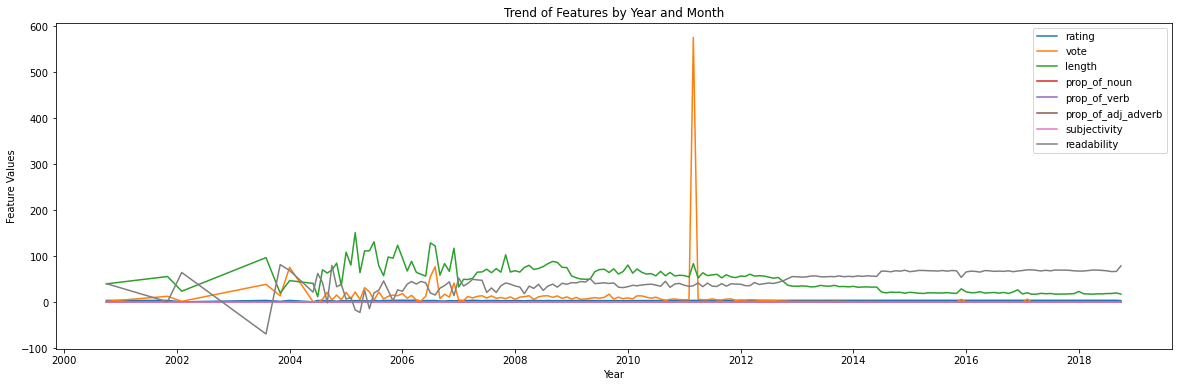

In [187]:
fig = plt.figure(figsize=(20, 6))
year_month = np.asarray(trend_data_by_year_month["year-month"], dtype='datetime64[s]')
plt.plot(year_month, trend_data_by_year_month["rating"], label = "rating")
plt.plot(year_month, trend_data_by_year_month["vote"], label = "vote")
plt.plot(year_month, trend_data_by_year_month["length"], label = "length")
plt.plot(year_month, trend_data_by_year_month["prop_of_noun"], label = "prop_of_noun")
plt.plot(year_month, trend_data_by_year_month["prop_of_verb"], label = "prop_of_verb")
plt.plot(year_month, trend_data_by_year_month["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
plt.plot(year_month, trend_data_by_year_month["subjectivity"], label = "subjectivity")
plt.plot(year_month, trend_data_by_year_month["readability"], label = "readability")
plt.xlabel("Year")
plt.ylabel("Feature Values")
#plt.xticks(rotation = 90)
plt.title("Trend of Features by Year and Month")
plt.legend()

[Text(0, 0.5, 'Feature Values'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Trend of readability by year and month')]

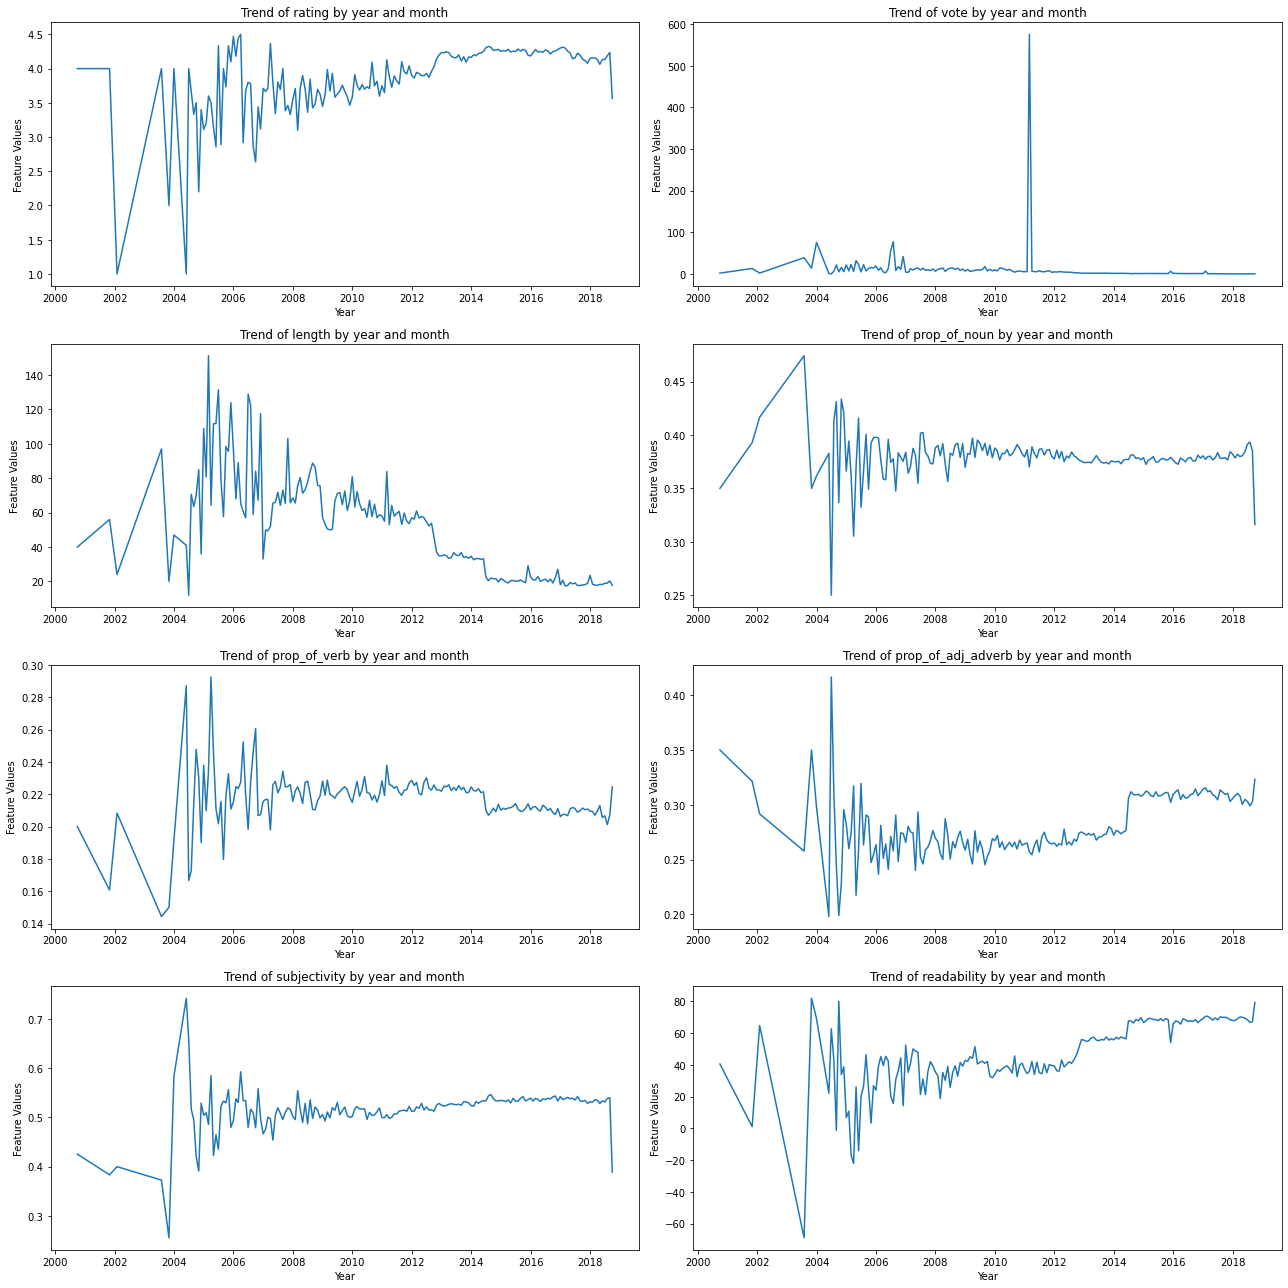

In [188]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(18, 18), tight_layout=True)
axes[0][0].plot(year_month, trend_data_by_year_month["rating"], label = "rating")
axes[0][0].set(title="Trend of rating by year and month", xlabel="Year", ylabel="Feature Values")
axes[0][1].plot(year_month, trend_data_by_year_month["vote"], label = "vote")
axes[0][1].set(title="Trend of vote by year and month", xlabel="Year", ylabel="Feature Values")
axes[1][0].plot(year_month, trend_data_by_year_month["length"], label = "length")
axes[1][0].set(title="Trend of length by year and month", xlabel="Year", ylabel="Feature Values")
axes[1][1].plot(year_month, trend_data_by_year_month["prop_of_noun"], label = "prop_of_noun")
axes[1][1].set(title="Trend of prop_of_noun by year and month", xlabel="Year", ylabel="Feature Values")
axes[2][0].plot(year_month, trend_data_by_year_month["prop_of_verb"], label = "prop_of_verb")
axes[2][0].set(title="Trend of prop_of_verb by year and month", xlabel="Year", ylabel="Feature Values")
axes[2][1].plot(year_month, trend_data_by_year_month["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
axes[2][1].set(title="Trend of prop_of_adj_adverb by year and month", xlabel="Year", ylabel="Feature Values")
axes[3][0].plot(year_month, trend_data_by_year_month["subjectivity"], label = "subjectivity")
axes[3][0].set(title="Trend of subjectivity by year and month", xlabel="Year", ylabel="Feature Values")
axes[3][1].plot(year_month, trend_data_by_year_month["readability"], label = "readability")
axes[3][1].set(title="Trend of readability by year and month", xlabel="Year", ylabel="Feature Values")

In [189]:
data_visual = data.copy()
data_visual.index = pd.to_datetime(data_visual.reviewTime)
data_visual = data_visual[["tagged_filtered","tokenized_filtered", "bigram", "rating", "vote", "sentiment"]]
data_visual = data_visual[data_visual.index>="2008"]
data_visual.head(10)

,tagged_filtered,tokenized_filtered,bigram,rating,vote,sentiment
reviewTime,,,,,,
2013-11-27,"[thing, book, seemed, obvious, original, thought, clarity, author, explains, innovation, happens, remarkable, gregerman, discusses, meaning, human, interactions, kinds, situations, tend, inspire, ...","[thing, book, seem, obvious, original, think, clarity, author, explain, innovation, happen, remarkable, gregerman, discuss, mean, human, interactions, kinds, situations, tend, inspire, original, c...","[not one, one thing, thing book, book seem, seem obvious, obvious original, original think, think however, however clarity, clarity author, author explain, explain innovation, innovation happen, h...",5.0,2.0,positive
2013-11-01,"[enjoyed, alan, blog, previous, books, taking, innovation, class, alan, decade, opened, eyes, seeing, world, fresh, way, taught, techniques, use, creative, problem, solving, skills, individuals, a...","[enjoy, alan, blog, previous, book, take, innovation, class, alan, decade, open, eye, see, world, fresh, way, teach, techniques, use, creative, problem, solve, skills, individuals, alan, differenc...","[enjoy alan, alan gregerman, gregerman weekly, weekly blog, blog two, two previous, previous book, book since, since take, take innovation, innovation class, class alan, alan decade, decade ago, a...",5.0,0.0,positive
2013-10-10,"[alan, gregerman, believes, innovation, comes, viewing, problems, different, fresh, perspectives, necessity, strangers, tells, short, simple, stories, help, free, current, legacy, views, problem, ...","[alan, gregerman, believe, innovation, come, view, problems, different, fresh, perspectives, necessity, strangers, tell, short, simple, stories, help, free, current, legacy, view, problem, hand, p...","[alan gregerman, gregerman believe, believe innovation, innovation come, come view, view problems, problems different, different fresh, fresh perspectives, perspectives the, the necessity, necessi...",5.0,0.0,positive
2013-10-09,"[smart, funny, entertaining, writer, point, view, encounter, stranger, alan, opens, mind, heart, new, possibilities, ability, spot, meaningful, connections, weave, compelling, stories, allows, lea...","[smart, funny, entertain, writer, point, view, encounter, strange, alan, open, mind, heart, new, possibilities, ability, spot, meaningful, connections, weave, compel, stories, allow, learn, rich, ...","[alan gregerman, gregerman smart, smart funny, funny entertain, entertain writer, writer jostle, jostle point, point view, view through, through every, every encounter, encounter strange, strange ...",5.0,0.0,positive
2013-09-07,"[began, book, reminded, complicated, word, stranger, refer, someone, heard, course, refer, someone, met, heard, know, nothing, type, stranger, someone, think, know, really, false, assumptions, min...","[begin, book, remind, complicate, word, strange, refer, someone, hear, course, refer, someone, meet, hear, know, nothing, type, strange, someone, think, know, really, false, assumptions, mindset, ...","[begin read, read book, book remind, remind deceptively, deceptively complicate, complicate word, word strange, strange could, could refer, refer someone, someone never, never hear, hear course, c...",5.0,10.0,positive
2014-05-11,"[teach, class, innovation, used, necessity, strangers, required, books, students, loved, book, book, piece, literature, turns, common, knowledge, networking, head, main, point, book, random, stran...","[teach, class, innovation, use, necessity, strangers, require, book, students, love, book, book, piece, literature, turn, common, knowledge, network, head, main, point, book, random, strangers, ab...","[teach class, class innovation, innovation use, use necessity, necessity strangers, strangers one, one require, require book, book the, the students, students love, love book, book the, the book, ...",5.0,0.0,positive
2014-05-09,"[appreciated, insights, book, allen, organizes, presents, ideas, beautifully, reminding, seeing, thin

In [200]:
import itertools

def most_common_word_func_tokenized(token_list, n_words=15):
    # Transform review tokens into word frequency distribution dataframe

    fdist = FreqDist(token_list) 
    
    # Synoym topics are counted together
    for keyword in synonym_dic:
        if keyword in fdist:
            fdist[synonym_dic[keyword]] += fdist[keyword]
            del fdist[keyword]
    
    # filter out the target topics which are most prevalant between 2013 and 2018
    fdist_filtered = {}
    for key, value in fdist.items():
        if key in target_keyword_list:
            fdist_filtered[key] = value
    
    n_words = n_words
    
    df_fdist = pd.DataFrame({'Word': fdist_filtered.keys(),
                             'Frequency': fdist_filtered.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

def word_dist(df_tmp):
    token_list = df_tmp.iloc[:,0].values
    return most_common_word_func_tokenized(itertools.chain.from_iterable(token_list))

# This is a manually constructed dictionary that matched all similar topics to the same keyword
synonym_dic = {"work great":"great quality", "work perfectly": "great quality", "great product": "great quality", 
                                       "would recommend": "great quality", "work good": "great quality",
                                       "highly recommend": "great quality", "work fine": "great quality", "would recommend": "great quality",
                                       "work well": "great quality", "exactly need": "great quality", "good quality": "great quality",
                                       "good product": "great quality", "great product": "great quality", "great quality":  "great quality",
                                       "love them": "great quality", "look great": "great quality", "well make": "great quality",
                                       "look good": "great quality", "really like": "great quality", "super cute": "great quality", "like picture": "great quality",
                            "fit perfect": "fit perfectly", "perfect fit": "fit perfectly", "fit well": "fit perfectly", "fit great": "fit perfectly", "fit expect": "fit perfectly",
                            "good price": "great price"}

# After the investigations in the code blocks below, these four topics are the most prevalant and popular topics across 2013-2018.
target_keyword_list = ["great quality", "fit perfectly", "great price", "fast ship"]

data_visual["unique_bigram"] = np.array([np.unique(np.array(token)) for token in data_visual["bigram"]])
data_freq_list = data_visual[["bigram"]].groupby(data_visual.index.strftime("%Y")).apply(word_dist)
data_freq_list # DataFrame: Year - keyword - number of reviews containing this keyword

Word  Frequency
reviewTime                            
2008       3  great quality         59
           0    great price         30
           1  fit perfectly         15
           2      fast ship          4
2009       3  great quality         94
           0    great price         42
           2  fit perfectly         42
           1      fast ship          6
2010       3  great quality        196
           1  fit perfectly        122
           0    great price        111
           2      fast ship         20
2011       1  fit perfectly        326
           3  great quality        319
           0    great price        236
           2      fast ship         45
2012       1  fit perfectly        854
           3  great quality        548
           0    great price        495
           2      fast ship         91
2013       1  fit perfectly       2652
           0    great price       1598
           3  great quality       1359
           2      fast ship        293
2014       2  fit perfectly       4774
           0    great price       2930
           3  great quality       1912
           1      fast ship       1004
2015       1  fit perfectly       7291
           0    great price       4159
           3  great quality       2341
           2      fast ship       1392
2016       0  fit perfectly      10210
           1    great price       5260
           3  great quality       2888
           2      fast ship       1436
2017       0  fit perfectly      10213
           1    great price       5142
           3  great quality       2477
           2      fast ship       1305
2018       0  fit perfectly       5809
           1    great price       2626
           3  great quality       1337
           2      fast ship        678

In [201]:
data_count_review = data_visual[["bigram"]].groupby(data_visual.index.strftime("%Y")).apply("count") # Year - # of reviews this year

data_freq_list_all = pd.merge(data_freq_list, data_count_review, left_index=True, right_index=True, how="inner")
data_freq_list_all["keyword_prop"] = data_freq_list_all["Frequency"] / data_freq_list_all["bigram"] # % of reviews containing this keyword
data_freq_list_all.rename(columns={"bigram":"num of reviews"}, inplace=True)
data_freq_list_all.index = [index[0] for index in data_freq_list_all.index]
data_freq_list_all

,Word,Frequency,num of reviews,keyword_prop
2008,great quality,59,1080,0.054630
2008,great price,30,1080,0.027778
2008,fit perfectly,15,1080,0.013889
2008,fast ship,4,1080,0.003704
2009,great quality,94,1781,0.052779
2009,great price,42,1781,0.023582
2009,fit perfectly,42,1781,0.023582
2009,fast ship,6,1781,0.003369
2010,great quality,196,3672,0.053377
2010,fit perfectly,122,3672,0.033224


In [202]:
# Reorder the dataframe by the # of reviews containing this keyword. We only want to focus on prevalant topics.
word_year_count = data_freq_list_all[["Word","keyword_prop", "Frequency"]].groupby("Word").agg(["count", "mean"])
word_year_count.sort_values(by=("keyword_prop", "count"), ascending=False)

keyword_prop           Frequency             
                     count      mean     count         mean
Word                                                       
fast ship               11  0.008865        11   570.363636
fit perfectly           11  0.060323        11  3846.181818
great price             11  0.037397        11  2057.181818
great quality           11  0.036434        11  1230.000000

In [203]:
# Create a new dataframe for visualization: entries are % of reviews in this year containing this keyword
data_freq_list_transformed = pd.DataFrame()
data_freq_list_transformed["great quality"] = data_freq_list_all[data_freq_list_all.Word == "great quality"]["keyword_prop"]
data_freq_list_transformed["fit perfectly"] = data_freq_list_all[data_freq_list_all.Word == "fit perfectly"]["keyword_prop"]
data_freq_list_transformed["great price"] = data_freq_list_all[data_freq_list_all.Word == "great price"]["keyword_prop"]
data_freq_list_transformed["fast ship"] = data_freq_list_all[data_freq_list_all.Word == "fast ship"]["keyword_prop"]
#data_freq_list_transformed["easy install"] = data_freq_list_all[data_freq_list_all.Word == "easy install"]["keyword_prop"]
data_freq_list_transformed

,great quality,fit perfectly,great price,fast ship
2008,0.054630,0.013889,0.027778,0.003704
2009,0.052779,0.023582,0.023582,0.003369
2010,0.053377,0.033224,0.030229,0.005447
2011,0.043166,0.044114,0.031935,0.006089
2012,0.039684,0.061844,0.035846,0.006590
2013,0.035384,0.069050,0.041607,0.007629
2014,0.029965,0.074819,0.045920,0.015735
2015,0.025308,0.078821,0.044962,0.015048
2016,0.024457,0.086465,0.044545,0.012161
2017,0.021765,0.089740,0.045182,0.011467


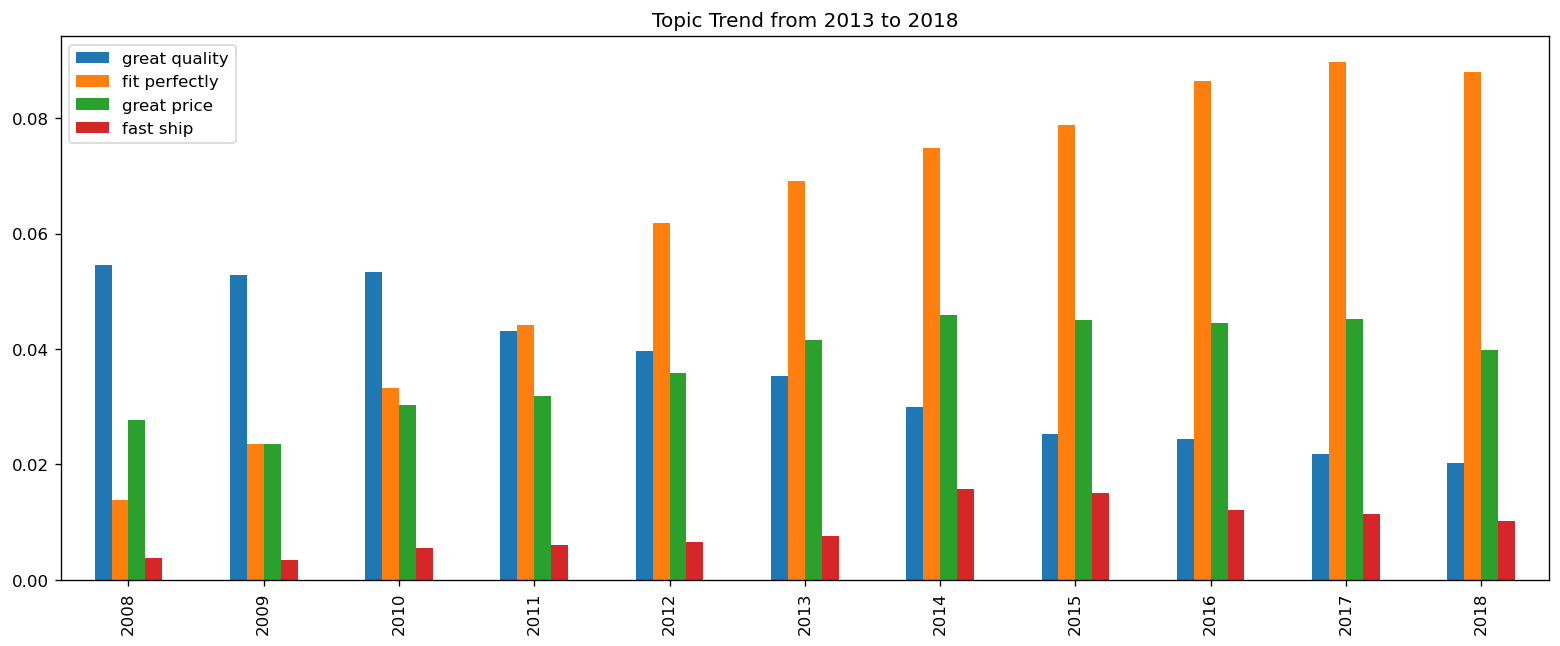

In [204]:
# Trend visualization
plt.rcParams["figure.dpi"] = 120
data_freq_list_transformed.plot(kind="bar", figsize=(16, 6), title="Topic Trend from 2013 to 2018")

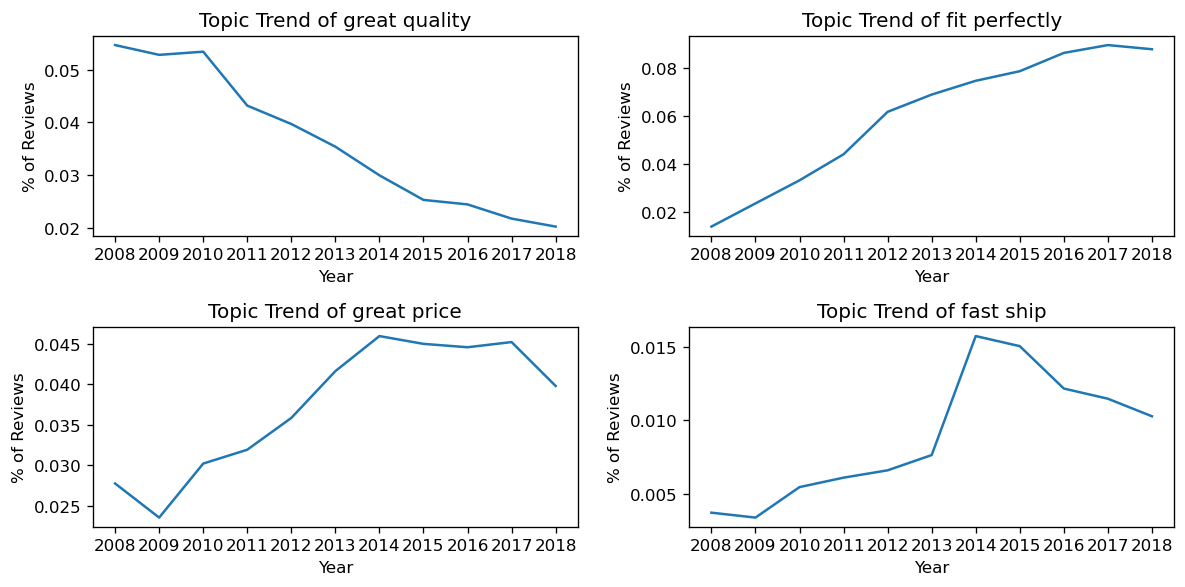

In [205]:
# Trend visualization
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5), tight_layout=True, dpi=120)
for index in range(len(data_freq_list_transformed.columns)):
    axes[index//2][index%2].plot(data_freq_list_transformed.index, data_freq_list_transformed.iloc[:, index])
    axes[index//2][index%2].set(xlabel="Year", ylabel="% of Reviews", 
                                                       title = "Topic Trend of "+data_freq_list_transformed.columns[index])

### Trend of Customer Satisfaction

In [206]:
# Visualization of the trend of % of positive/neutral/negative reviews across time

data_satisfaction = data_visual[["sentiment", "bigram"]].groupby([data_visual.index.strftime("%Y"), "sentiment"]).count()
data_satisfaction

bigram
reviewTime sentiment        
2008       negative      307
           neutral        78
           positive      695
2009       negative      482
           neutral       157
           positive     1142
2010       negative      902
           neutral       267
           positive     2503
2011       negative     1596
           neutral       460
           positive     5334
2012       negative     2679
           neutral       829
           positive    10301
2013       negative     5430
           neutral      2411
           positive    30566
2014       negative     8285
           neutral      3662
           positive    51860
2015       negative    12451
           neutral      5037
           positive    75013
2016       negative    16286
           neutral      6657
           positive    95140
2017       negative    17446
           neutral      5698
           positive    90662
2018       negative    11473
           neutral      3345
           positive    51190

In [207]:
data_sat_all = pd.merge(data_satisfaction, data_count_review, left_index=True, right_index=True, how="inner")
data_sat_all["% of reviews"] = data_sat_all["bigram_x"] / data_sat_all["bigram_y"] # % of reviews containing this keyword
data_sat_all.rename(columns={"bigram_x":"num of reviews", "bigram_y":"total reviews"}, inplace=True)
data_sat_all.reset_index(inplace=True)
data_sat_all.index = data_sat_all["reviewTime"]
data_sat_all.drop(columns="reviewTime", inplace=True)
data_sat_all

,sentiment,num of reviews,total reviews,% of reviews
reviewTime,,,,
2008,negative,307,1080,0.284259
2008,neutral,78,1080,0.072222
2008,positive,695,1080,0.643519
2009,negative,482,1781,0.270634
2009,neutral,157,1781,0.088153
2009,positive,1142,1781,0.641213
2010,negative,902,3672,0.245643
2010,neutral,267,3672,0.072712
2010,positive,2503,3672,0.681645


In [208]:
# Create a new dataframe for visualization: entries are % of reviews in this year containing this keyword
data_sat_all_transformed = pd.DataFrame()
data_sat_all_transformed["positive"] = data_sat_all[data_sat_all.sentiment == "positive"]["% of reviews"]
data_sat_all_transformed["neutral"] = data_sat_all[data_sat_all.sentiment == "neutral"]["% of reviews"]
data_sat_all_transformed["negative"] = data_sat_all[data_sat_all.sentiment == "negative"]["% of reviews"]
data_sat_all_transformed

,positive,neutral,negative
reviewTime,,,
2008,0.643519,0.072222,0.284259
2009,0.641213,0.088153,0.270634
2010,0.681645,0.072712,0.245643
2011,0.721786,0.062246,0.215968
2012,0.745963,0.060033,0.194004
2013,0.795845,0.062775,0.141380
2014,0.812763,0.057392,0.129845
2015,0.810943,0.054453,0.134604
2016,0.805704,0.056376,0.137920


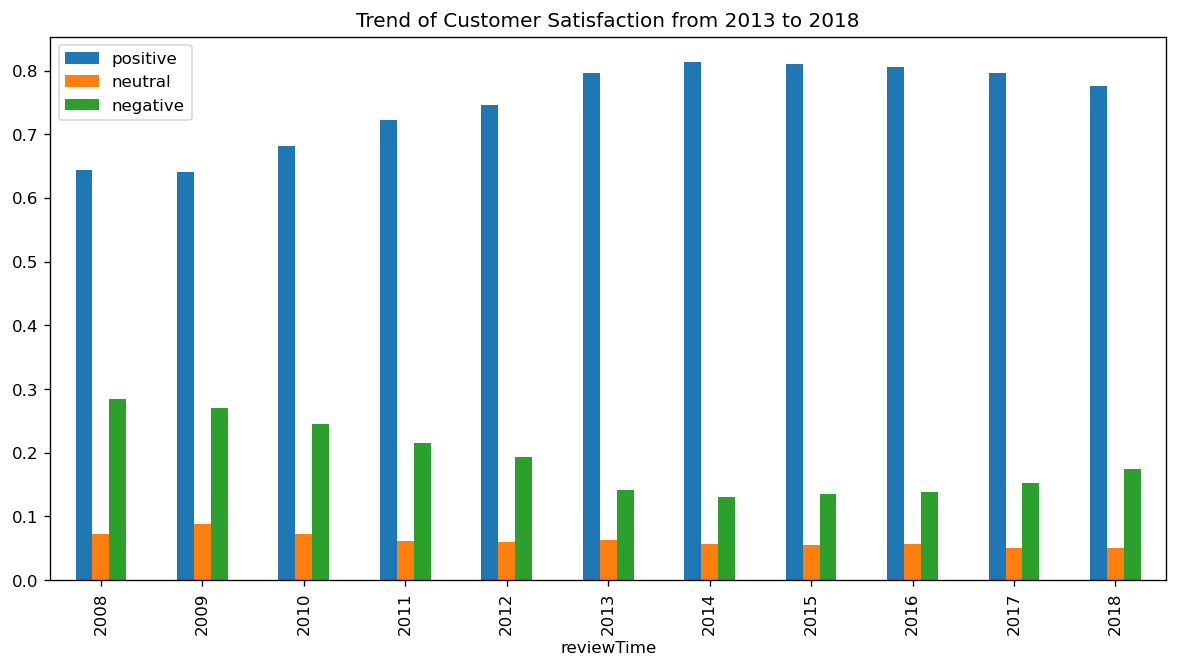

In [209]:
plt.rcParams["figure.dpi"] = 120
data_sat_all_transformed.plot(kind="bar", figsize=(12, 6), title="Trend of Customer Satisfaction from 2013 to 2018")